<a href="https://colab.research.google.com/github/andrewkallai/MLTSA25_AKallai/blob/main/HW3/ARIMA__instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
import pandas as pd
import numpy as np
import pylab as pl
import glob
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [85]:
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

In [86]:
import warnings
warnings.filterwarnings('ignore')

In [87]:
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/fbb.mplstyle")

TASK 1: data ingestion

TASK 2: data exploration

TASK 3: test each time series for stationarity

TASK 4: Inspect the partial autocorrelation with plots

TASK 5: fit an ARIMA model to each time series with appriopriate parameters

# REMEMBER: CAPTIONS FOR EVERY PLOT!!!

#  TASK 1: data ingestion

In [88]:
# download kaggle economic data
# https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/data#a.us.txt


In [89]:
!pip install kaggle

In [90]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [91]:
%cd /content/gdrive/MyDrive/.kaggle

/content/gdrive/MyDrive/.kaggle


In [92]:
envs = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']


## now make a director to save the MLTSA 2025 data into - call it MLTSA25

In [93]:
%mkdir /content/gdrive/MyDrive/MLTSA25

mkdir: cannot create directory ‘/content/gdrive/MyDrive/MLTSA25’: File exists


In [94]:
%cd /content/gdrive/MyDrive/MLTSA25

/content/gdrive/MyDrive/MLTSA25


## make a HW3 folder

In [95]:
%mkdir HW3

mkdir: cannot create directory ‘HW3’: File exists


In [96]:
%cd HW3

/content/gdrive/MyDrive/MLTSA25/HW3


## download the kaggle data _note: you may need to go to the specificl challenge and agree to the terms of competition_

In [97]:
!kaggle datasets download borismarjanovic/price-volume-data-for-all-us-stocks-etfs

Dataset URL: https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs
License(s): CC0-1.0
price-volume-data-for-all-us-stocks-etfs.zip: Skipping, found more recently modified local copy (use --force to force download)


In [98]:
!ls

Data  ETFs  price-volume-data-for-all-us-stocks-etfs.zip  Stocks


## uncompress the file

In [99]:
!unzip price-volume-data-for-all-us-stocks-etfs.zip

Archive:  price-volume-data-for-all-us-stocks-etfs.zip
replace Data/ETFs/aadr.us.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [100]:
# use glob to sort the files alphabetically
alltss = []

allfiles = np.sort(np.array(glob.glob("Data/Stocks/*.txt")))
tss = pd.read_csv(allfiles[0])[["Date", "Close"]].rename({"Close":
              allfiles[0].replace(".txt",
                                  "").replace("Data/Stocks/",
                                              "")}, axis=1)
for f in allfiles[1:11]:
    print(f)
    name = f.replace(".txt","").replace("Data/Stocks/", "")

    tss = tss.merge(pd.read_csv(f)[["Date", "Close"]].rename({"Close":
                                                              name},
                                        axis=1), on="Date")
tss.set_index("Date", inplace=True)


Data/Stocks/aa.us.txt
Data/Stocks/aaap.us.txt
Data/Stocks/aaba.us.txt
Data/Stocks/aac.us.txt
Data/Stocks/aal.us.txt
Data/Stocks/aamc.us.txt
Data/Stocks/aame.us.txt
Data/Stocks/aan.us.txt
Data/Stocks/aaoi.us.txt
Data/Stocks/aaon.us.txt


Now you have a dataframe with 10 columns of data and two years of measurements

# TASK 2:  data exploration

- inspect the files by, e.g., printing some content and printing their statistical properties
- plot each time series (ts)
- inspect correlation
# inspect the file

In [101]:
print(tss.head())


              a.us   aa.us  aaap.us  aaba.us  aac.us  aal.us  aamc.us  \
Date                                                                    
2015-11-11  36.901  17.779    24.50    33.38   22.56  43.524    20.75   
2015-11-12  36.734  17.206    25.00    33.23   22.50  43.044    19.17   
2015-11-13  36.030  17.581    25.26    32.19   22.68  42.603    17.50   
2015-11-16  36.577  18.242    25.02    32.94   22.58  41.994    15.58   
2015-11-17  37.607  18.197    24.62    32.86   22.52  41.473    12.59   

            aame.us  aan.us  aaoi.us  aaon.us  
Date                                           
2015-11-11   4.7960  24.649    16.76   24.252  
2015-11-12   4.8951  24.182    16.11   23.652  
2015-11-13   4.6672  23.795    16.60   23.110  
2015-11-16   4.8455  23.923    16.93   23.130  
2015-11-17   4.9150  23.418    16.68   23.268  


In [102]:
print(tss.describe())

             a.us       aa.us     aaap.us     aaba.us      aac.us      aal.us  \
count  447.000000  447.000000  447.000000  447.000000  447.000000  447.000000   
mean    48.787649   28.434510   36.750649   44.218737   13.871387   41.942794   
std      9.034588    8.818682   10.642928   10.756682    6.071919    6.066181   
min     34.193000   14.831000   23.720000   26.760000    6.050000   24.916000   
25%     41.239500   20.950000   29.720000   36.660000    8.040000   37.982500   
50%     46.228000   28.080000   35.020000   42.080000   11.400000   42.059000   
75%     55.956500   34.595000   38.525000   49.640000   19.600000   46.530000   
max     68.370000   50.080000   81.000000   72.220000   24.720000   53.992000   

          aamc.us     aame.us      aan.us     aaoi.us     aaon.us  
count  447.000000  447.000000  447.000000  447.000000  447.000000  
mean    45.783325    3.875367   29.626879   33.240678   30.040465  
std     31.608792    0.432411    7.248519   22.352541    5.021530 

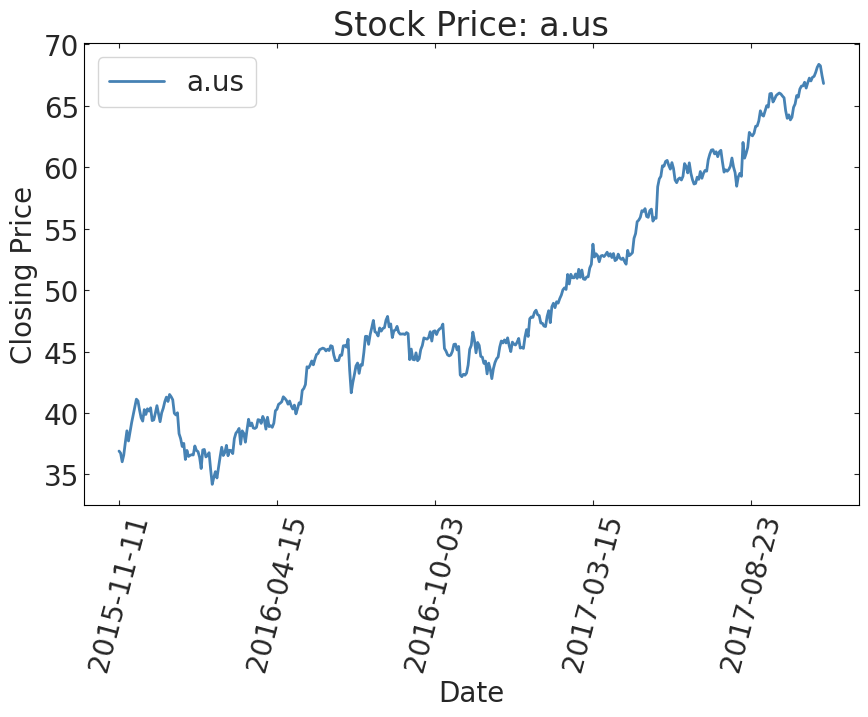

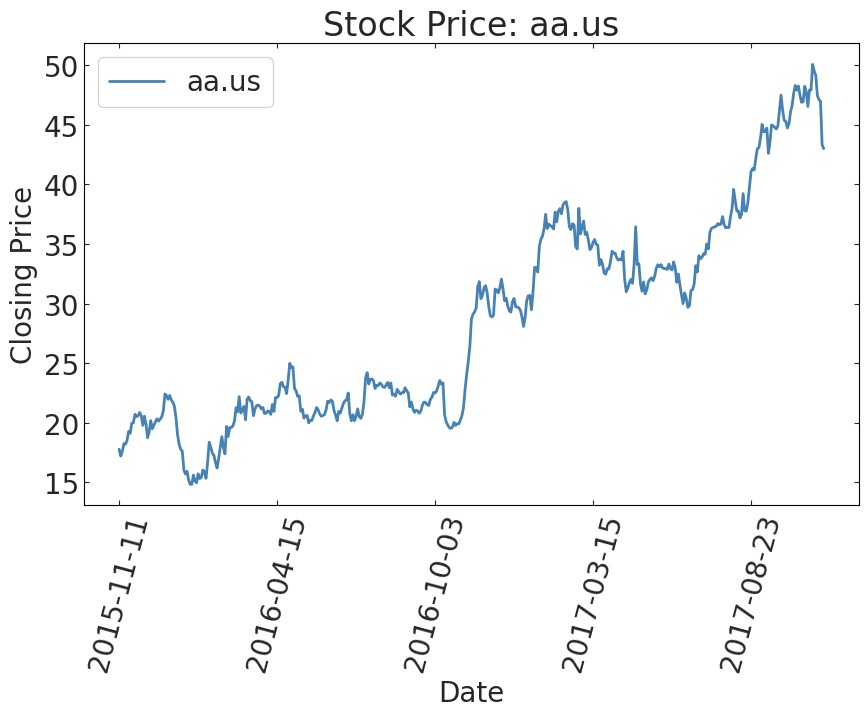

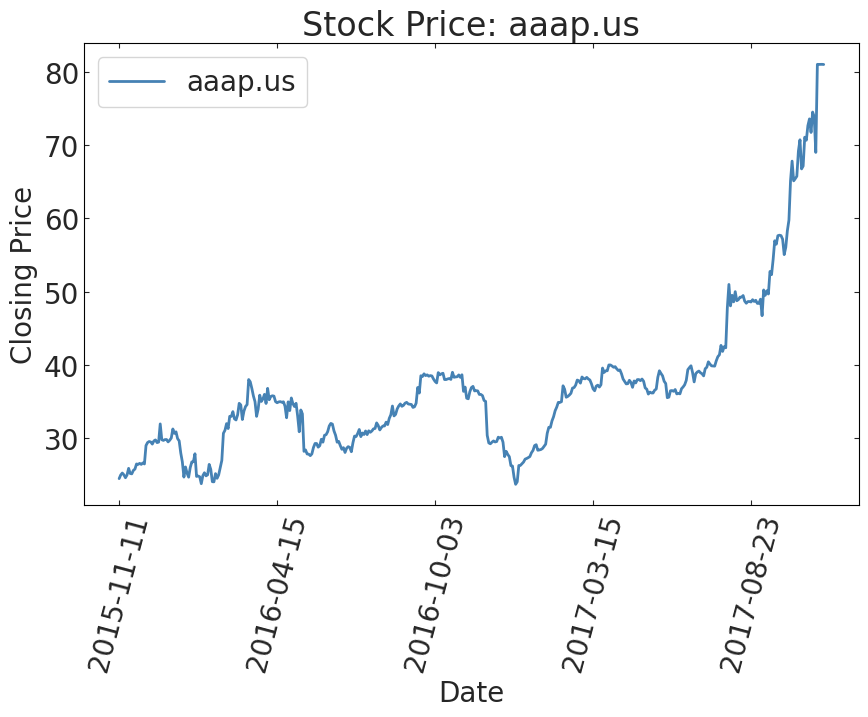

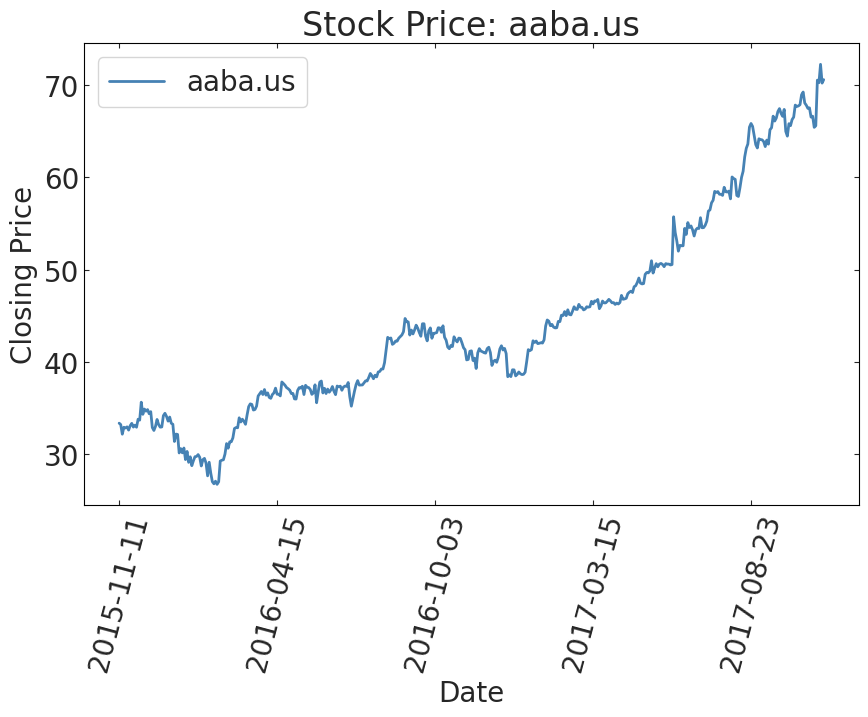

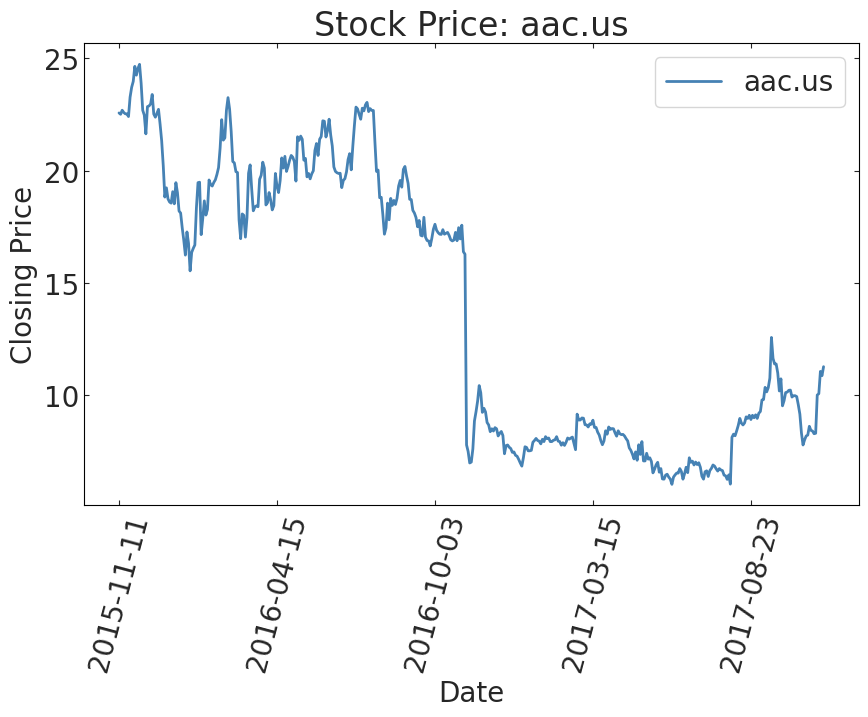

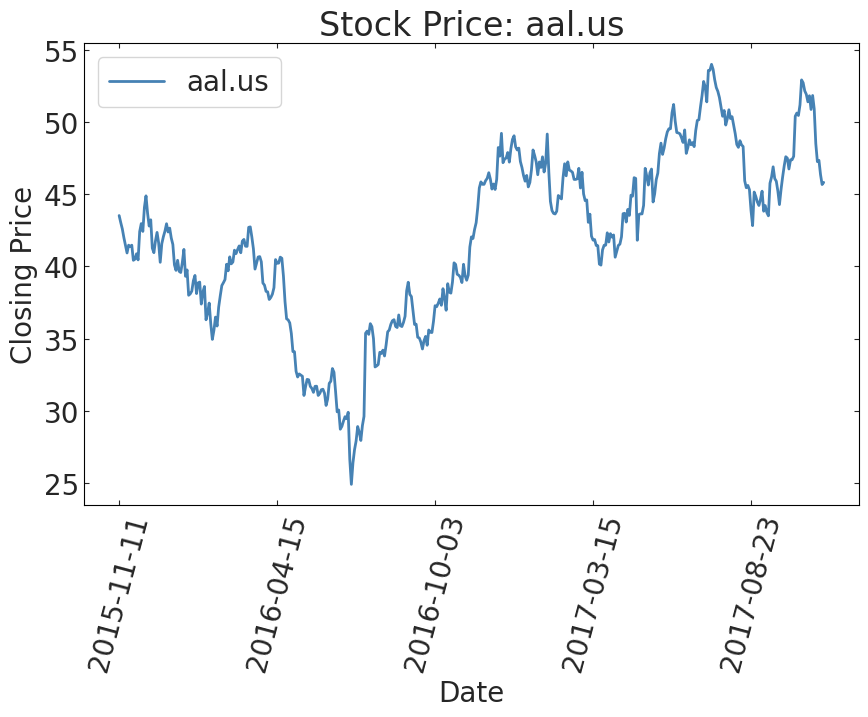

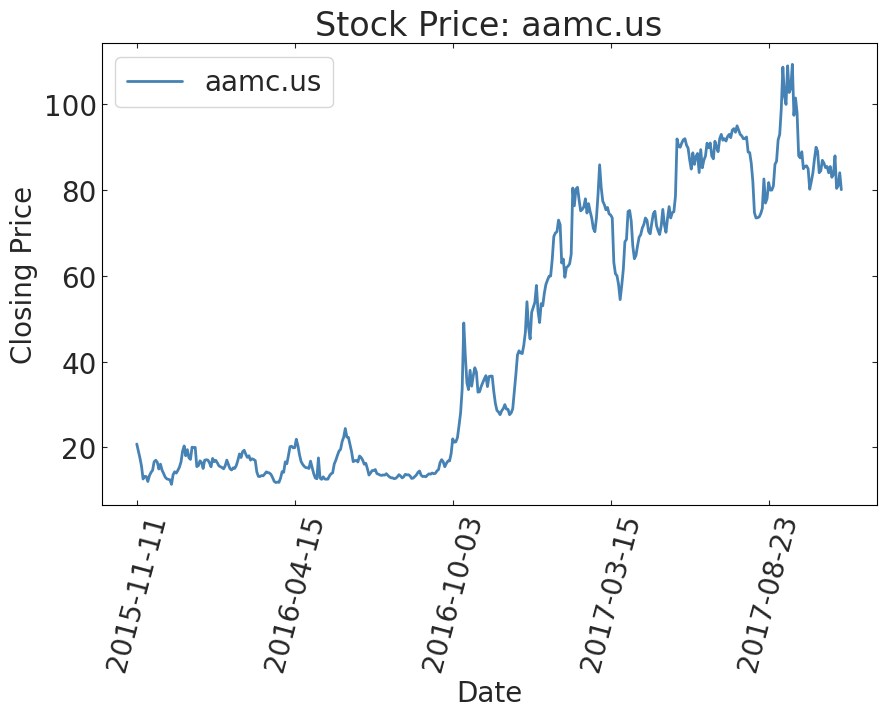

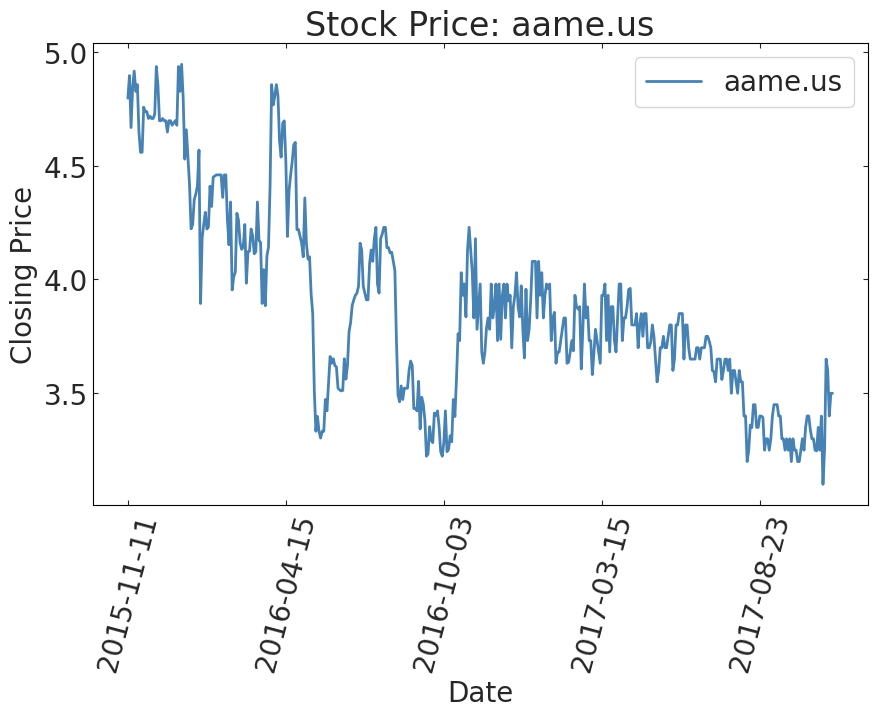

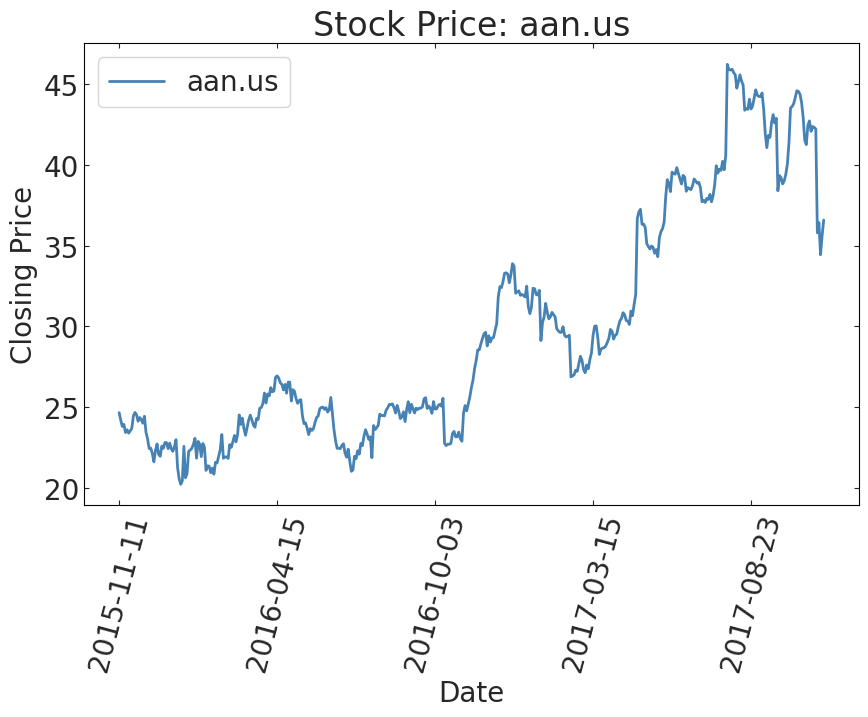

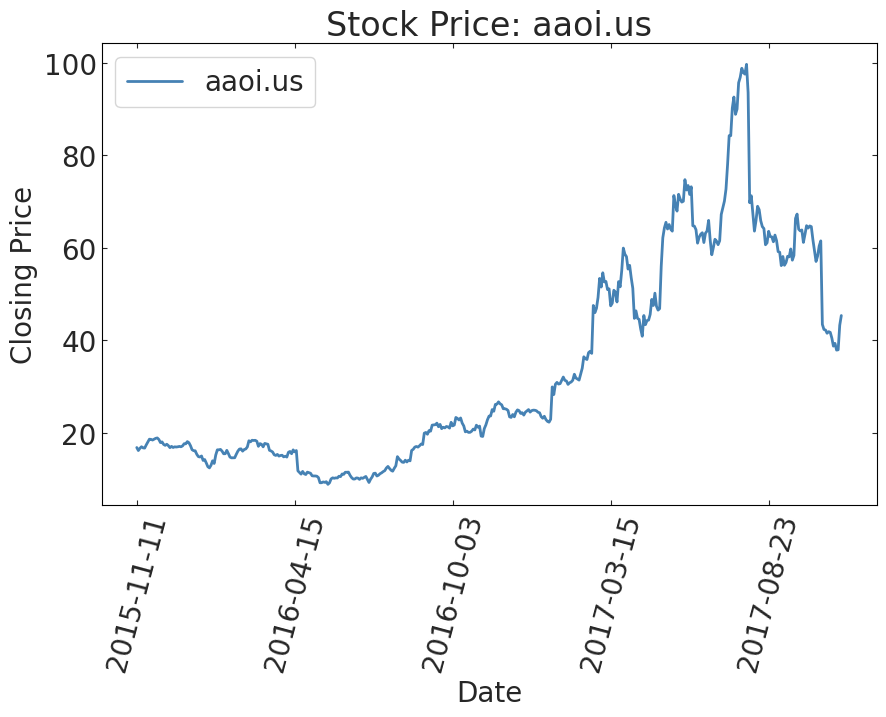

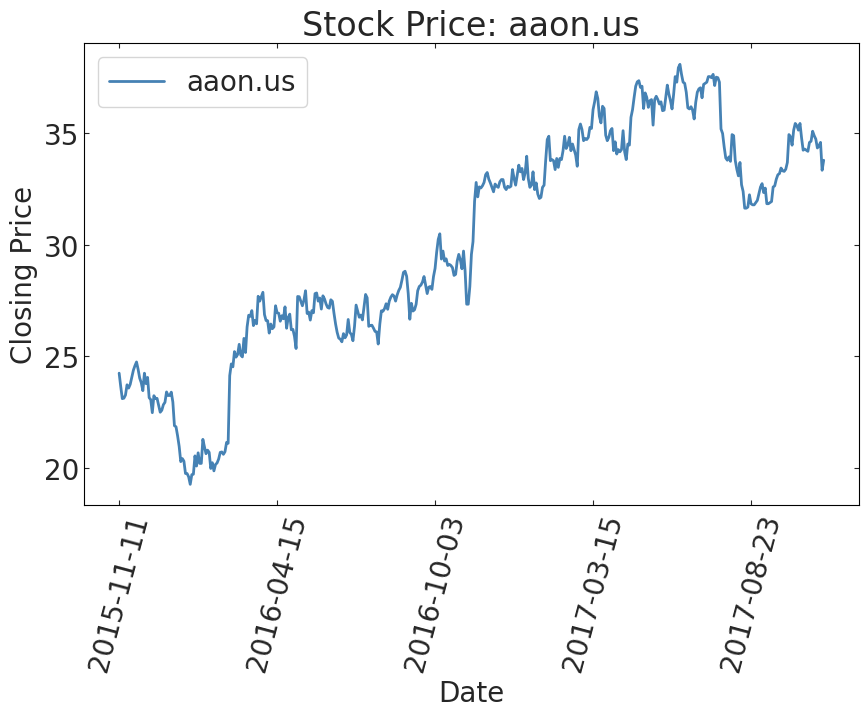

In [103]:
# plot all 10, for example in a for loop
# example of one plot - there are other ways to do it of course!

for column in tss.columns:
    tss.plot(y=column, rot=75, lw=2, title=f"Stock Price: {column}")
    plt.ylabel("Closing Price")
    plt.xlabel("Date")
    plt.show()



**Fig 1** plots historical closing prices of individual stocks (e.g., a.us), with dates on the x-axis and price values on the y-axis. Line graphs illustrate trends, volatility, and potential turning points, highlighting sustained growth, declines, or erratic fluctuations. The visualization aids investors in identifying high-risk assets, breakout opportunities, or long-term prospects through observable patterns like price stability, sharp spikes, or prolonged downtrends.

### visualizing correlations

use ```pandas.plotting.scatter_matrix```  to look at the relationship between lightcurves

plot the pairwise correlation as a heatmap using ```pl.imshow()```. You can access the pairwise correlation with the dataframe method ```df.corr()```

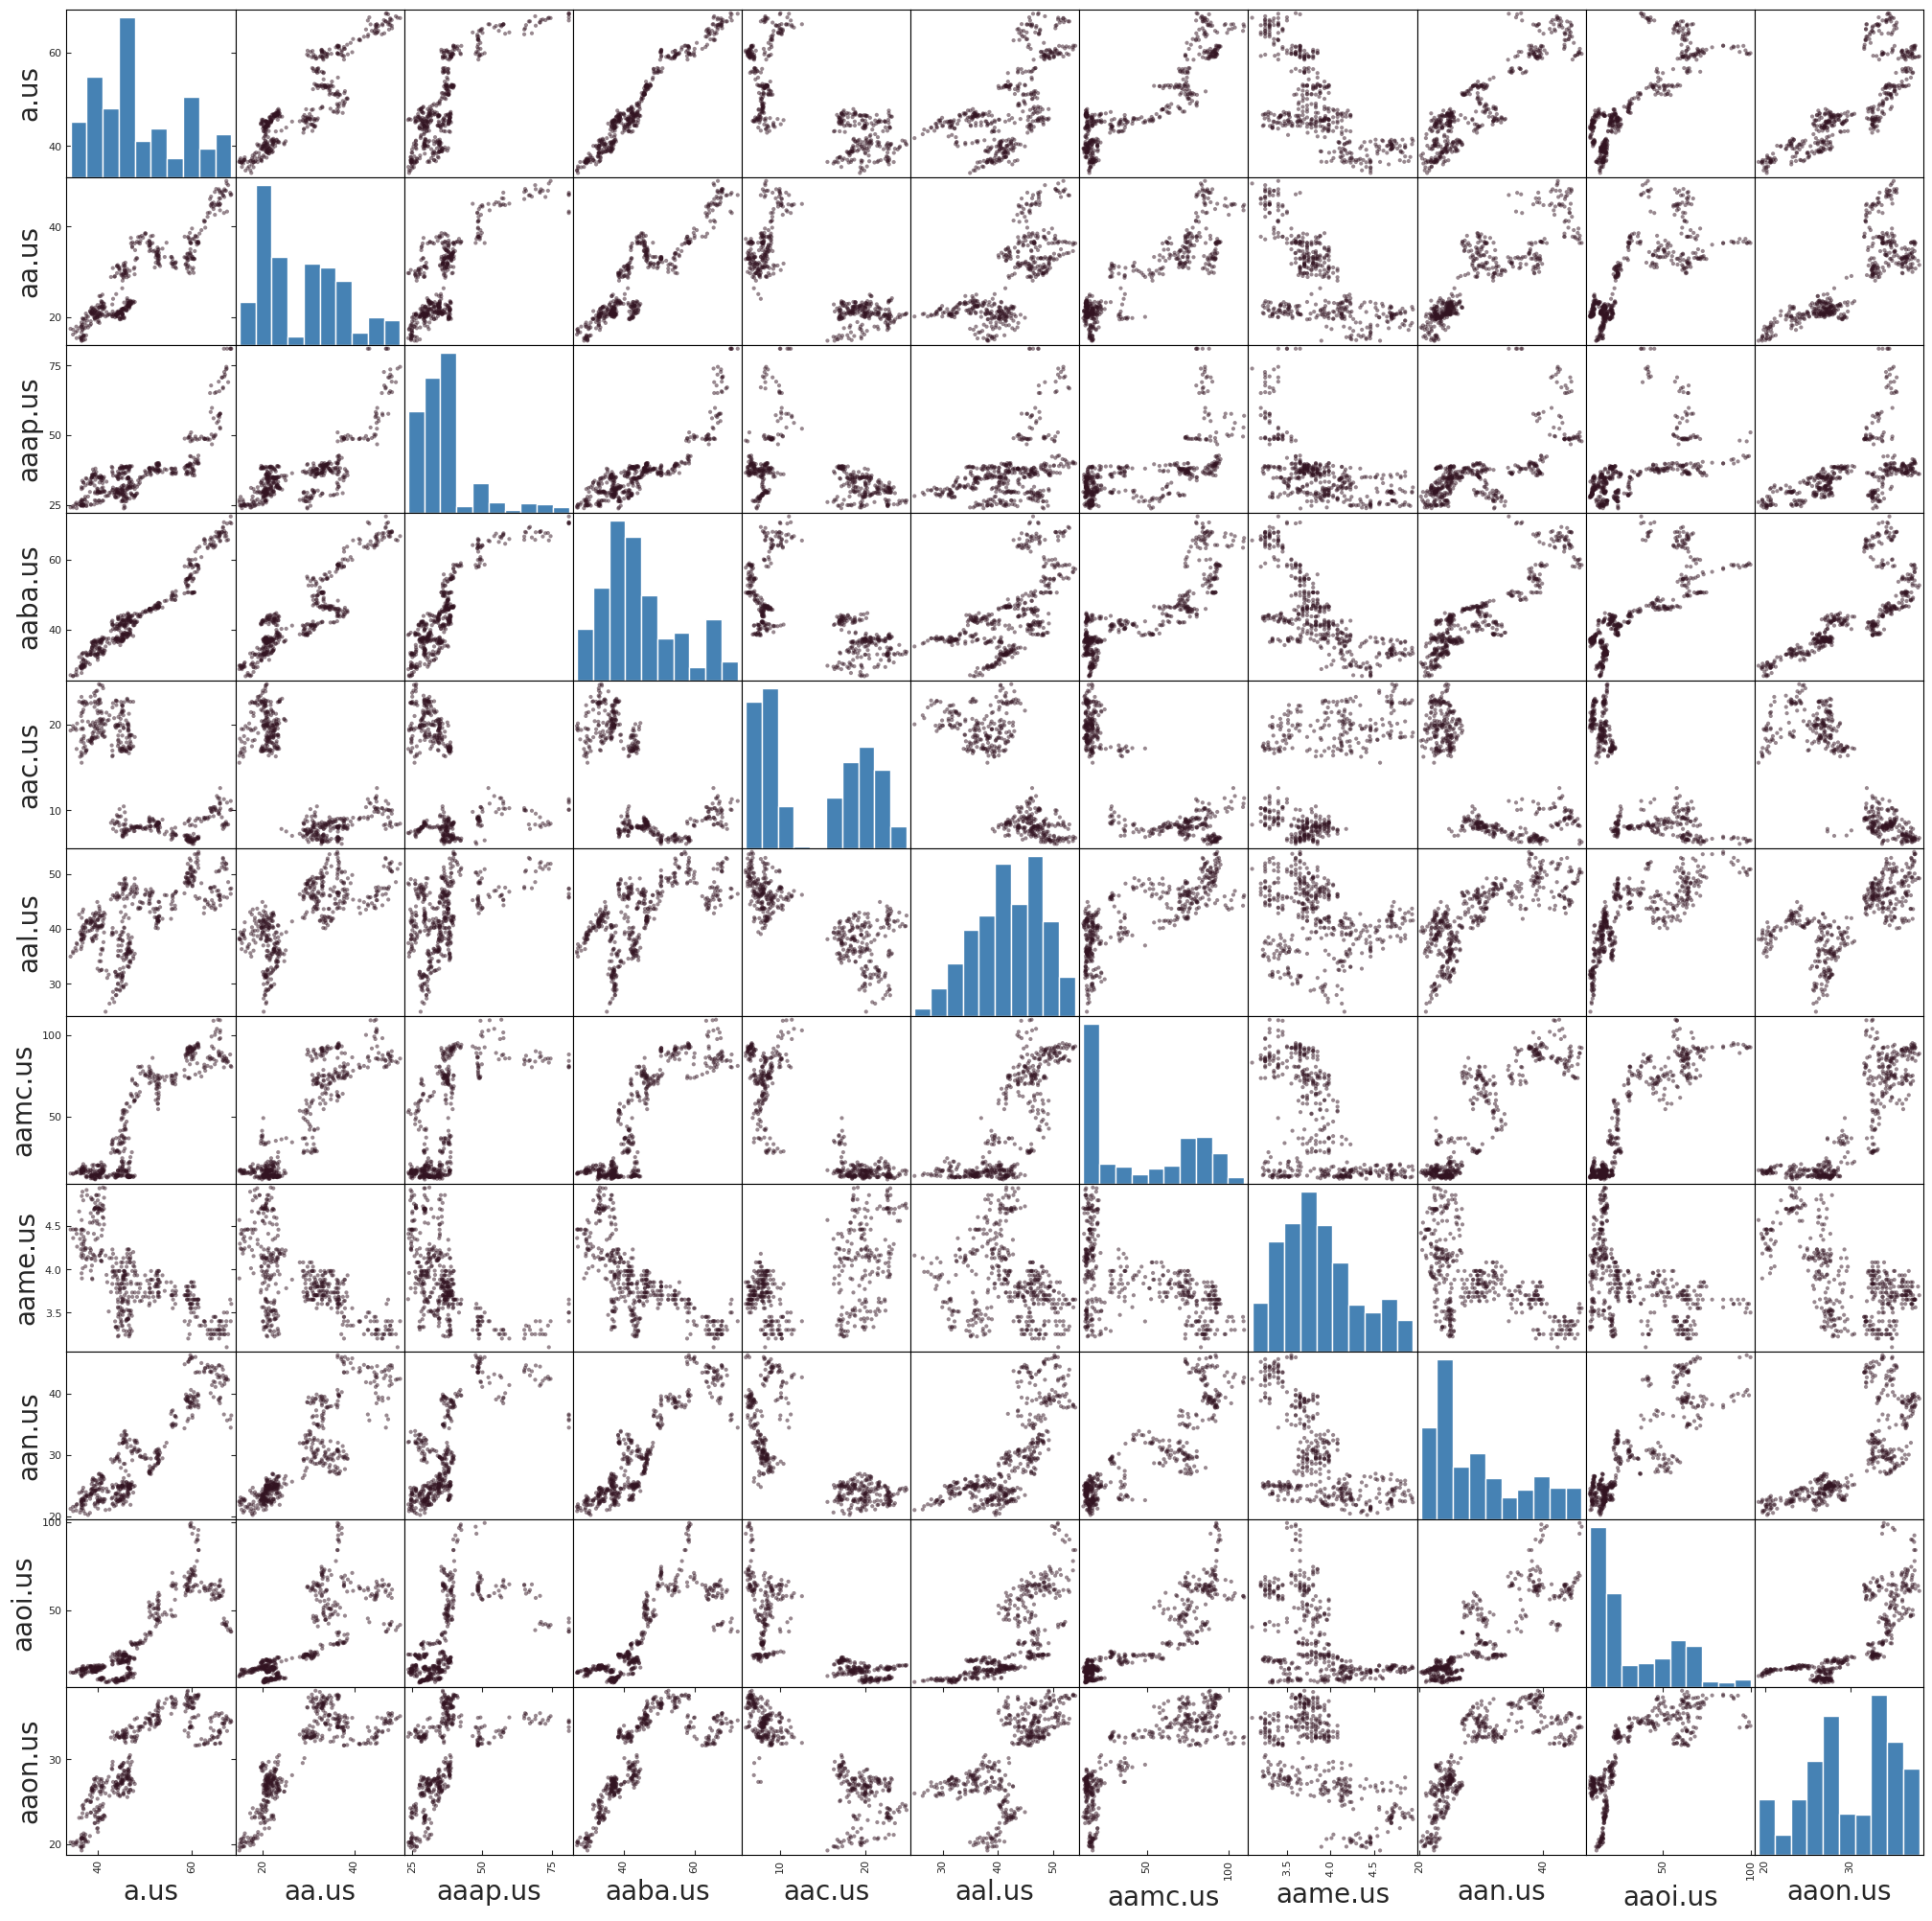

In [104]:
scatter_matrix(tss, figsize=(25,25), color="#321321");

**Fig 2** presents a matrix combining scatter plots and histograms to analyze stock correlations. Diagonal histograms depict individual closing price distributions, while off-diagonal scatter plots map pairwise relationships between equities. The matrix reveals clusters, outliers, and interdependencies, aiding in identifying synchronized trends, divergence patterns, or portfolio diversification strategies. By quantifying statistical linkages, it uncovers latent market dynamics, enabling traders to pinpoint correlated assets or hedge risks based on historical co-movements.

In [105]:
print("Correlation matrix of 2015-2017 stock values")
tss.corr()

Correlation matrix of 2015-2017 stock values


a.us     aa.us   aaap.us   aaba.us    aac.us    aal.us   aamc.us  \
a.us     1.000000  0.902139  0.800310  0.973457 -0.721867  0.621041  0.897263   
aa.us    0.902139  1.000000  0.776600  0.904210 -0.791137  0.713229  0.893952   
aaap.us  0.800310  0.776600  1.000000  0.872134 -0.423021  0.451520  0.621329   
aaba.us  0.973457  0.904210  0.872134  1.000000 -0.670578  0.612989  0.849972   
aac.us  -0.721867 -0.791137 -0.423021 -0.670578  1.000000 -0.785248 -0.868936   
aal.us   0.621041  0.713229  0.451520  0.612989 -0.785248  1.000000  0.780517   
aamc.us  0.897263  0.893952  0.621329  0.849972 -0.868936  0.780517  1.000000   
aame.us -0.699609 -0.606774 -0.573976 -0.709023  0.510986 -0.219258 -0.544740   
aan.us   0.905395  0.873520  0.696179  0.903785 -0.765267  0.756808  0.881631   
aaoi.us  0.851239  0.766459  0.560427  0.809059 -0.780147  0.746505  0.904166   
aaon.us  0.809409  0.809966  0.503524  0.755263 -0.876358  0.671816  0.853182   

          aame.us    aan.us   aaoi.us   aaon.us  
a.us    -0.699609  0.905395  0.851239  0.809409  
aa.us   -0.606774  0.873520  0.766459  0.809966  
aaap.us -0.573976  0.696179  0.560427  0.503524  
aaba.us -0.709023  0.903785  0.809059  0.755263  
aac.us   0.510986 -0.765267 -0.780147 -0.876358  
aal.us  -0.219258  0.756808  0.746505  0.671816  
aamc.us -0.544740  0.881631  0.904166  0.853182  
aame.us  1.000000 -0.585002 -0.496371 -0.612453  
aan.us  -0.585002  1.000000  0.860847  0.765596  
aaoi.us -0.496371  0.860847  1.000000  0.780400  
aaon.us -0.612453  0.765596  0.780400  1.000000

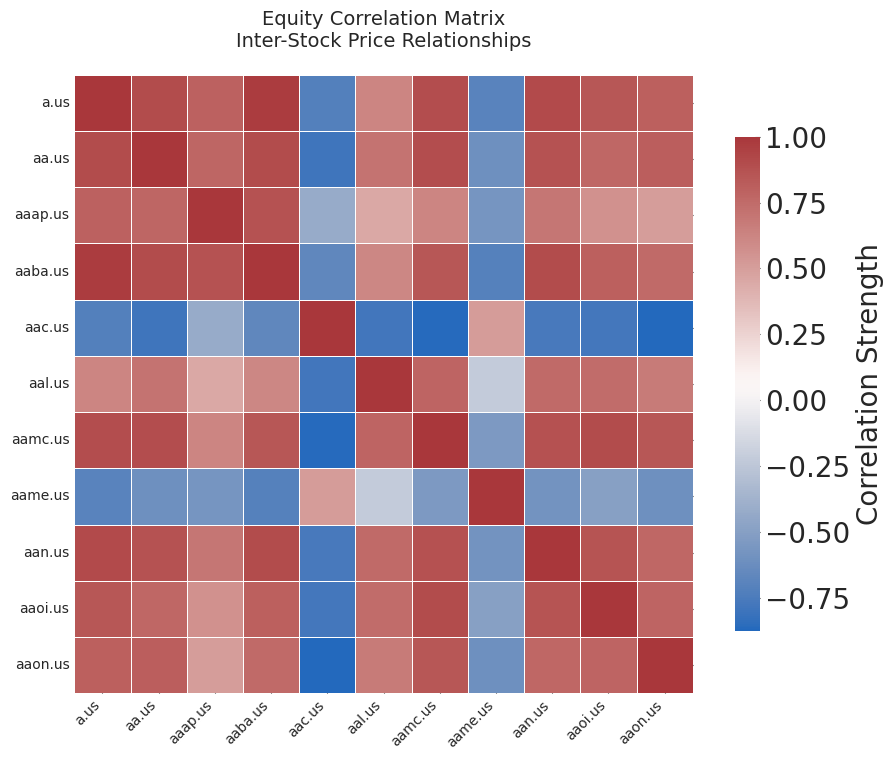

In [106]:
#Show the correlation as a heatmap

plt.figure(figsize=(10, 8))
sns.heatmap(
    tss.corr(),
    cmap="vlag",  # Diverging blue-red palette optimized for heatmaps
    annot=False,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8, 'label': 'Correlation Strength'}
)
plt.xticks(
    rotation=45,
    ha='right',
    fontsize=10
)
plt.yticks(
    rotation=0,
    fontsize=10
)
plt.title(
    "Equity Correlation Matrix\nInter-Stock Price Relationships",
    fontsize=14,
    pad=20
)
plt.tight_layout()
plt.show()

**Fig 3** visualizes pairwise stock correlations through a color-coded matrix, quantifying interdependence using a diverging gradient (blue = inverse relationships, red = strong positive alignment). Axis labels denote stock pairs, with color intensity reflecting correlation coefficients. The heatmap enables portfolio diversification by exposing redundant directional movements and identifies strategic pairing opportunities through behavioral similarities. It serves as a risk management tool for minimizing overexposure and a discovery mechanism for assets with complementary or mirrored price dynamics.

# TASK 3: test each time series for stationarity

## this will allow you to choose the parameter i in the ARIMA model: `i=0` for stationary time series, `i=1` for non stationary time series

The AD fuller test implementation which we saw in class is here
https://github.com/fedhere/MLTSA_FBianco/blob/main/CodeExamples/ARMA/testingARMA_ARIMA.ipynb

## testing for stationarity
test if each of these time series is stationary using the AD fuller test using `statsmodels.api.tsa.stattools.adfuller()`

```
for f in tss.columns:
    sm.tsa.stattools.adfuller(tss[c])
```

Have the code automatically print a statement about wheather the ts is stationary for each ts (for example in a for loop).

In [107]:

threshold = 0.05
print(f"ADF Stationarity Analysis (α = {threshold})\n{'='*40}")
print ("Stationarity results from the AD Fuller test at a p-value of 0.05")
for c in tss.columns:
  unittest = sm.tsa.stattools.adfuller(tss[c])
  print(c, unittest) # use the ADfuller test that we tried in class - that notebook is here  https://github.com/fedhere/MLTSA_FBianco/blob/main/CodeExamples/ARMA/testingARMA_ARIMA.ipynb

# Dictionary to store test metrics
stationarity_results = OrderedDict()

for symbol in tss.columns:
    adf_result = sm.tsa.stattools.adfuller(tss[symbol])
    test_stat, pval, _, _, crit_vals, _ = adf_result

    # Store results with critical values
    stationarity_results[symbol] = {
        'statistic': test_stat,
        'p-value': pval,
        'stationary': pval < threshold,
        '1%': crit_vals['1%'],
        '5%': crit_vals['5%'],
        '10%': crit_vals['10%']
    }

    # Formatted output
    print(f"\n{symbol}:")
    print(f"ADF Statistic = {test_stat:.3f} (Critical 1% = {crit_vals['1%']:.3f})")
    print(f"P-value: {pval:.4f} | Stationary: {pval < threshold}")
    print("-" * 50)

# Create binary stationarity list matching column order
stationary_list = [int(res['stationary']) for res in stationarity_results.values()]

# Final summary
print(f"\nSummary: {sum(stationary_list)}/{len(tss.columns)} series stationary")
pd.DataFrame.from_dict(stationarity_results, orient='index')

ADF Stationarity Analysis (α = 0.05)
Stationarity results from the AD Fuller test at a p-value of 0.05
a.us (0.17979485746634596, 0.9711053061077951, 1, 445, {'1%': -3.4451307246616514, '5%': -2.86805689169311, '10%': -2.570241263729327}, 805.5248587554438)
aa.us (-0.6405303185574794, 0.8615583755460212, 0, 446, {'1%': -3.4450973903602367, '5%': -2.868042229965336, '10%': -2.570233448893}, 1045.624076312899)
aaap.us (2.6589712655309765, 0.9990837483738163, 10, 436, {'1%': -3.445437655635993, '5%': -2.8681918844944785, '10%': -2.5703132171113543}, 1398.3285551584795)
aaba.us (1.5446998318251526, 0.9976818114588439, 3, 443, {'1%': -3.4451978474132234, '5%': -2.8680864144212057, '10%': -2.5702569996789792}, 983.6152372642052)
aac.us (-1.5712417694431973, 0.4980216243419859, 0, 446, {'1%': -3.4450973903602367, '5%': -2.868042229965336, '10%': -2.570233448893}, 881.5142131277471)
aal.us (-1.5522003683500403, 0.507548899130731, 0, 446, {'1%': -3.4450973903602367, '5%': -2.868042229965336, '1

statistic   p-value  stationary        1%        5%       10%
a.us      0.179795  0.971105       False -3.445131 -2.868057 -2.570241
aa.us    -0.640530  0.861558       False -3.445097 -2.868042 -2.570233
aaap.us   2.658971  0.999084       False -3.445438 -2.868192 -2.570313
aaba.us   1.544700  0.997682       False -3.445198 -2.868086 -2.570257
aac.us   -1.571242  0.498022       False -3.445097 -2.868042 -2.570233
aal.us   -1.552200  0.507549       False -3.445097 -2.868042 -2.570233
aamc.us  -0.805151  0.817604       False -3.445334 -2.868146 -2.570289
aame.us  -2.952678  0.039556        True -3.445131 -2.868057 -2.570241
aan.us   -1.060946  0.730392       False -3.445097 -2.868042 -2.570233
aaoi.us  -1.338283  0.611481       False -3.445198 -2.868086 -2.570257
aaon.us  -1.269508  0.643004       False -3.445097 -2.868042 -2.570233

NOTE: keep track of which time series is stationary and which one is not - when you model with ARIMA you can set the second parameter to 0 if it is stationary

# TASK 4: Inspect the partial autocorrelation with plots -
## this will help you choose the value of the parameter p in the ARIMA model: `p=N` where N is the largest statistically significant lag in the partial autocorrelation


<Figure size 1200x800 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

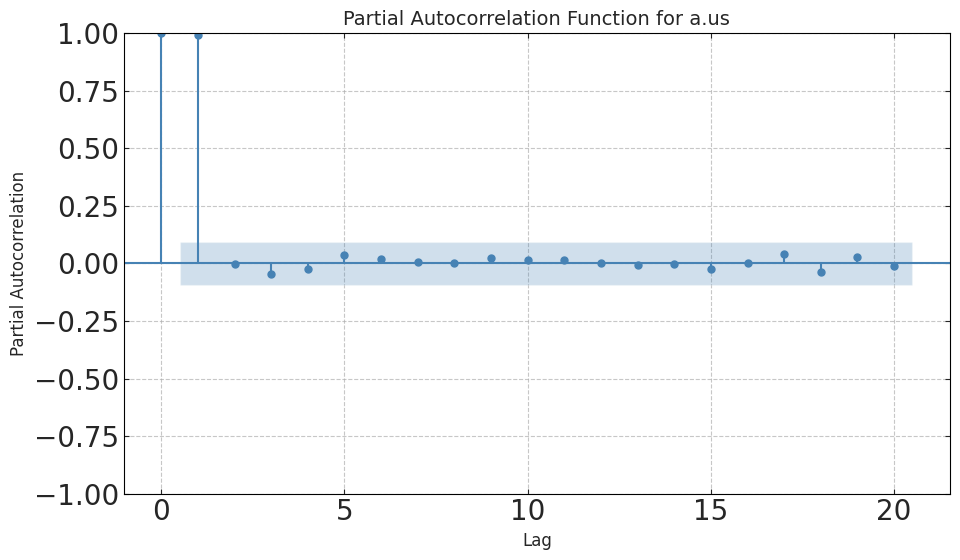

<Figure size 1000x600 with 0 Axes>

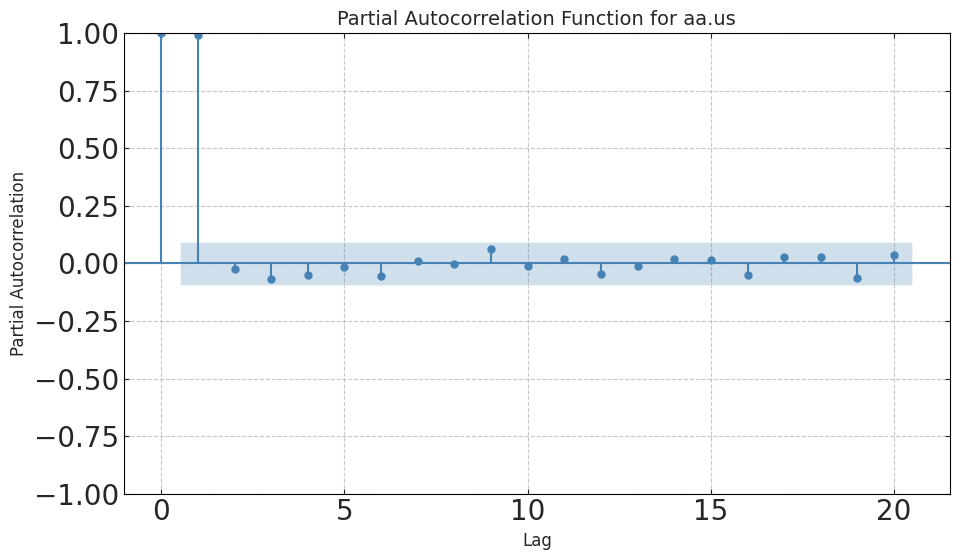

<Figure size 1000x600 with 0 Axes>

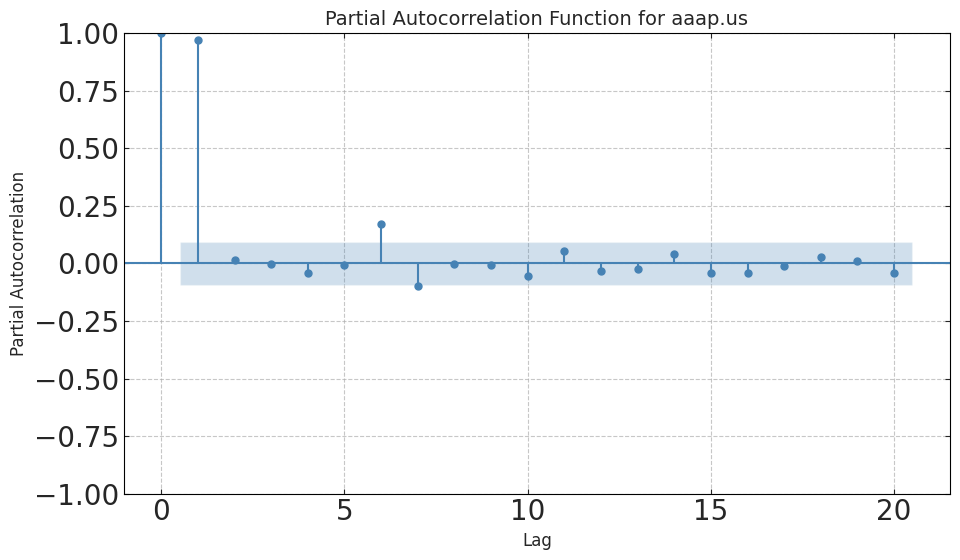

<Figure size 1000x600 with 0 Axes>

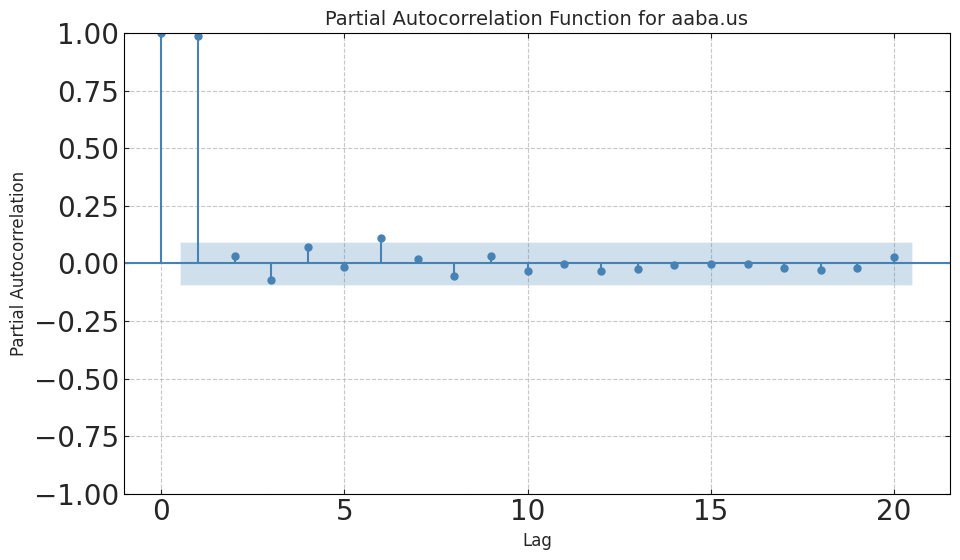

<Figure size 1000x600 with 0 Axes>

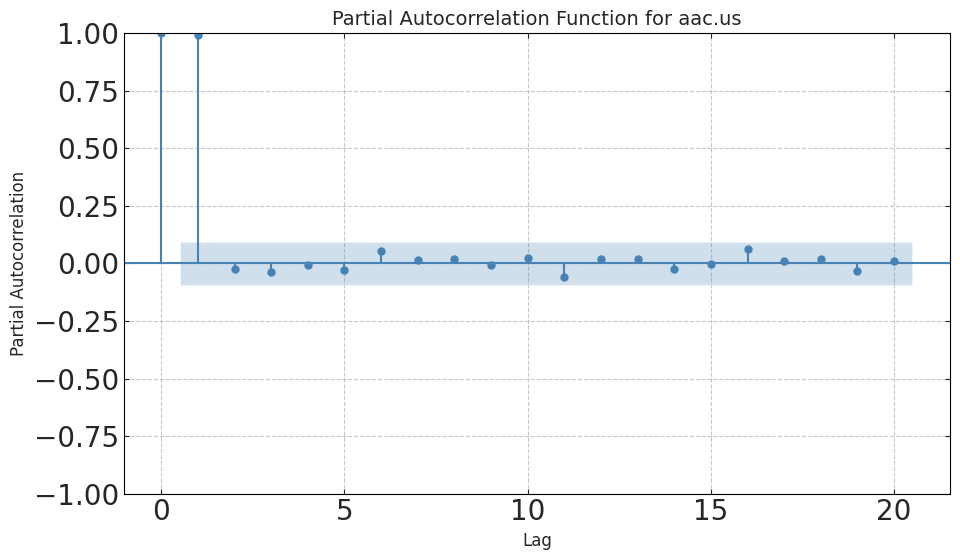

<Figure size 1000x600 with 0 Axes>

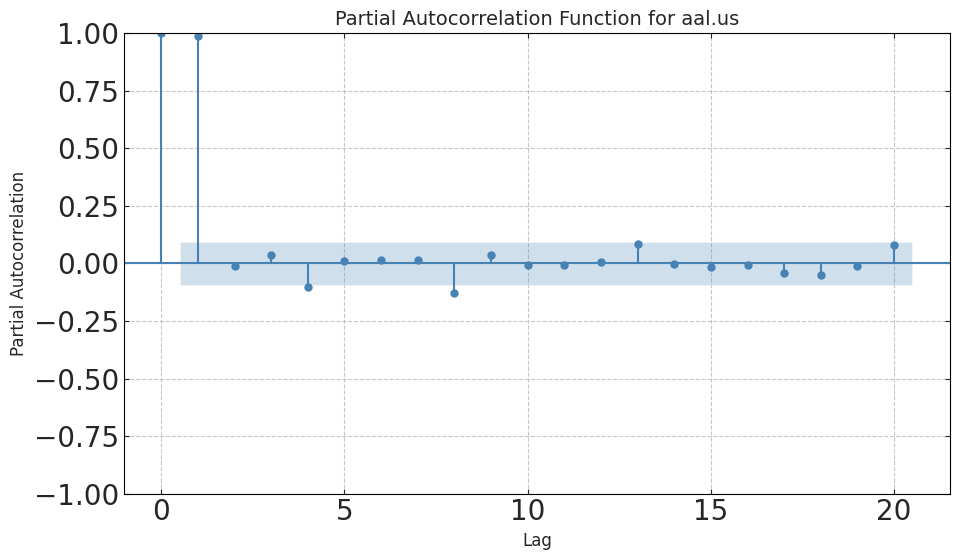

<Figure size 1000x600 with 0 Axes>

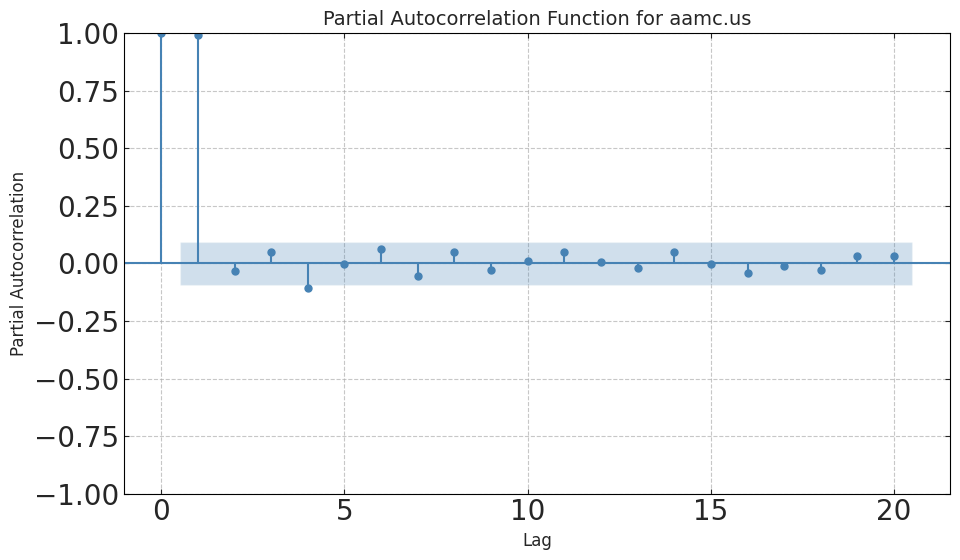

<Figure size 1000x600 with 0 Axes>

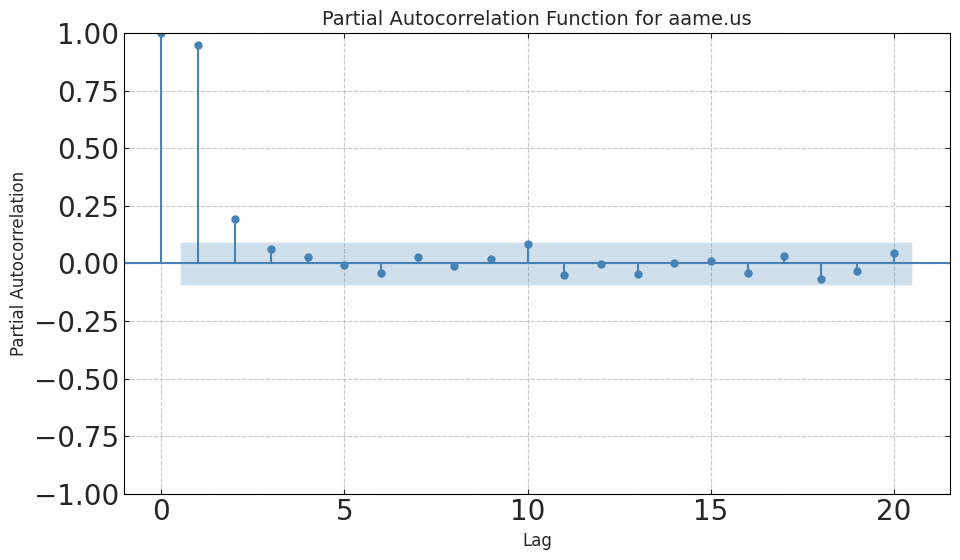

<Figure size 1000x600 with 0 Axes>

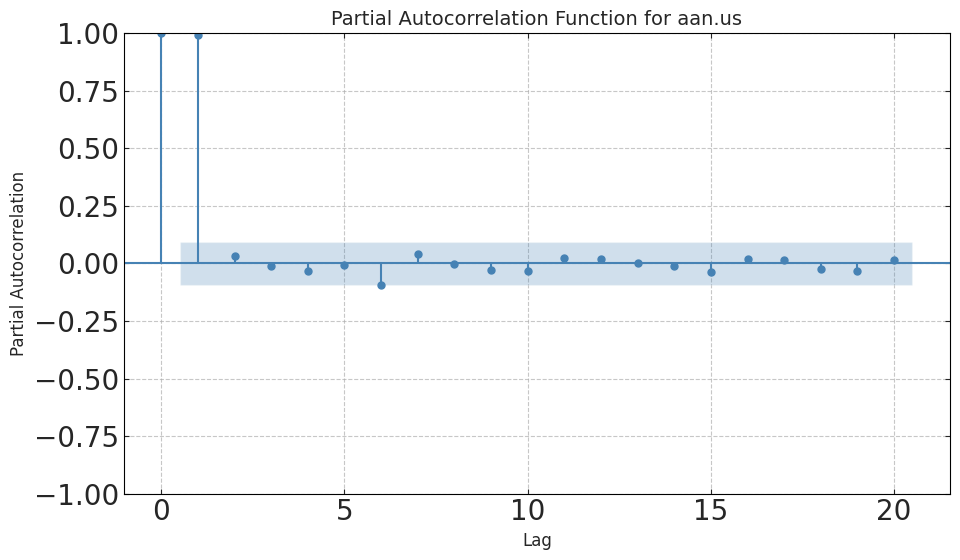

<Figure size 1000x600 with 0 Axes>

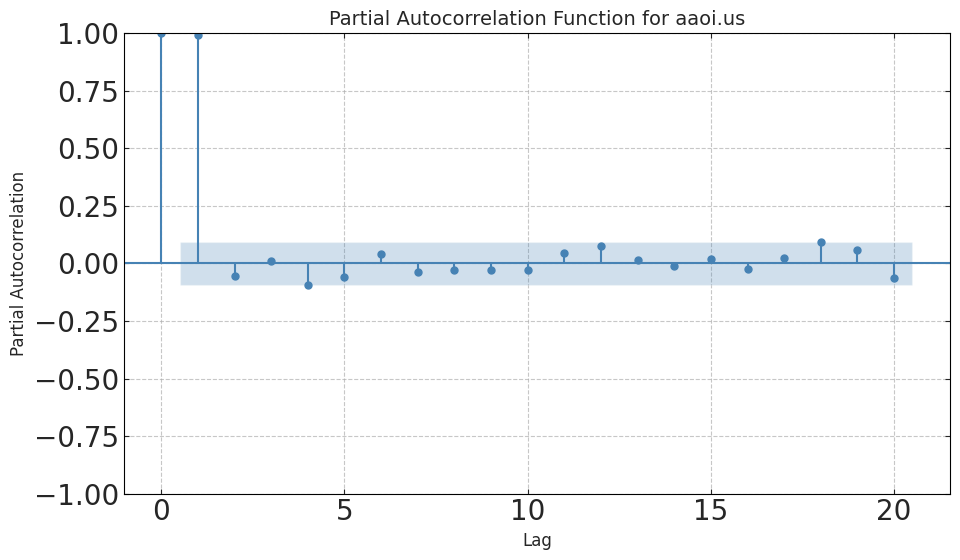

<Figure size 1000x600 with 0 Axes>

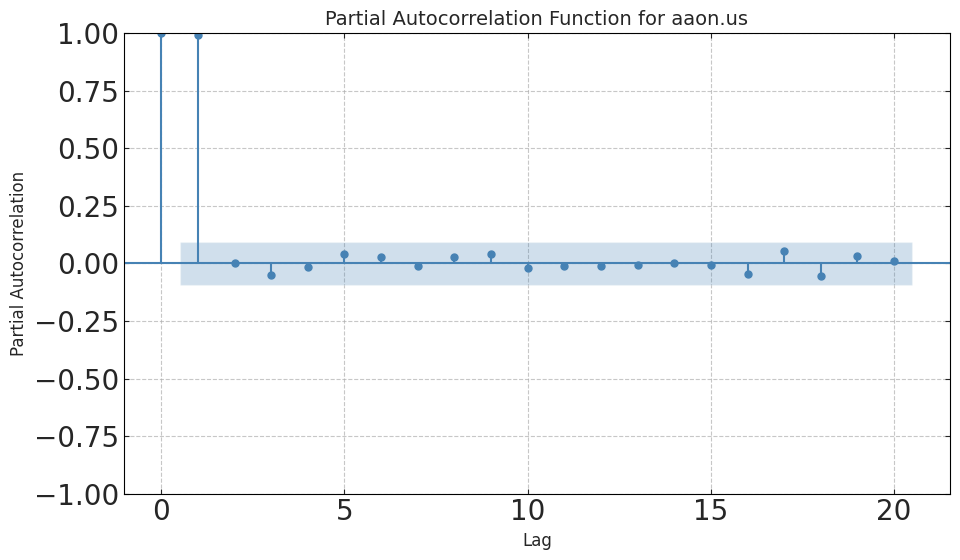

Top series by maximum PACF value:


In [108]:


# Create a figure with more appropriate size
plt.figure(figsize=(12, 8))

# Store maximum PACF values for each column
maxlist = []

#partial autocorrelatin plot

# Loop through each column in the time series dataframe
for c in tss.columns:
    # Create a new subplot for each column
    plt.figure(figsize=(10, 6))

    # Generate the PACF plot
    pacf_values = sm.graphics.tsa.plot_pacf(tss[c].dropna(), lags=20, alpha=0.05)

    # Store the maximum PACF value


    # Enhance the plot appearance
    plt.title(f'Partial Autocorrelation Function for {c}', fontsize=14)
    plt.xlabel('Lag', fontsize=12)
    plt.ylabel('Partial Autocorrelation', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Sort and display the series with highest PACF values
maxlist.sort(key=lambda x: x[1], reverse=True)
print("Top series by maximum PACF value:")
for series, value in maxlist:
    print(f"{series}: {value:.4f}")

FIG 4: Partial autocorrelation plots for the analyzed stock portfolio. Each panel displays the PACF coefficients (vertical axis) across different time lags (horizontal axis) for an individual stock. Significant coefficients outside the confidence bands (dashed blue lines) indicate potential autoregressive relationships at those specific lags, helping identify appropriate parameters for ARIMA modeling and revealing temporal dependencies in stock price movements.

# TASK 5: fit an ARIMA model to each time series
- look here for how to use the statsmodels ARIMA function https://www.geeksforgeeks.org/arma-time-series-model/
- the ARIMA function has 3 parameters: (p,i,q) see slide https://slides.com/d/EfsBk3o/live#/12; choose the values of _p_ according to your pacf plot and _i_ according to your stationarity analysis. _q_ is harder to guess... pick whatever you want for now

For each time series, use the all but the last 60 points for training and show the prediction based on the last 60 points



In [109]:
# to run the model for 1 column:

column_name = "aal.us"
N_test = 60
p = 7
i = 1 # 1 - not stationary, 0 - stationary
q = 3

arma_model = sm.tsa.ARIMA(tss.iloc[:-60][column_name], order=(p, i, q))
model_fit = arma_model.fit()
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 aal.us   No. Observations:                  387
Model:                 ARIMA(7, 1, 3)   Log Likelihood                -507.269
Date:                Mon, 17 Mar 2025   AIC                           1036.538
Time:                        03:53:28   BIC                           1080.052
Sample:                             0   HQIC                          1053.794
                                - 387                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0204      0.063     -0.325      0.745      -0.143       0.102
ar.L2          0.0037      0.066      0.056      0.956      -0.126       0.133
ar.L3          1.0411      0.070     14.978      0.000       0.905       1.177
ar.L4         -0.0285      0.083     -0.344      0.731      -0.191       0.134
ar.L5          0.0430      0.059      0.726      0.468      -0.073       0.159
ar.L6         -0.1230      0.063     -1.955      0.051      -0.246       0.000
ar.L7          0.0587      0.063      0.928      0.353      -0.065       0.183
ma.L1          0.0244      1.545      0.016      0.987      -3.003       3.052
ma.L2         -0.0508      1.577     -0.032      0.974      -3.142       3.040
ma.L3         -0.9734      1.503     -0.648      0.517      -3.919       1.972
sigma2         0.8066      1.222      0.660      0.509      -1.588       3.201
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               484.04
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             0.26
Prob(H) (two-sided):                  0.07   Kurtosis:                         8.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

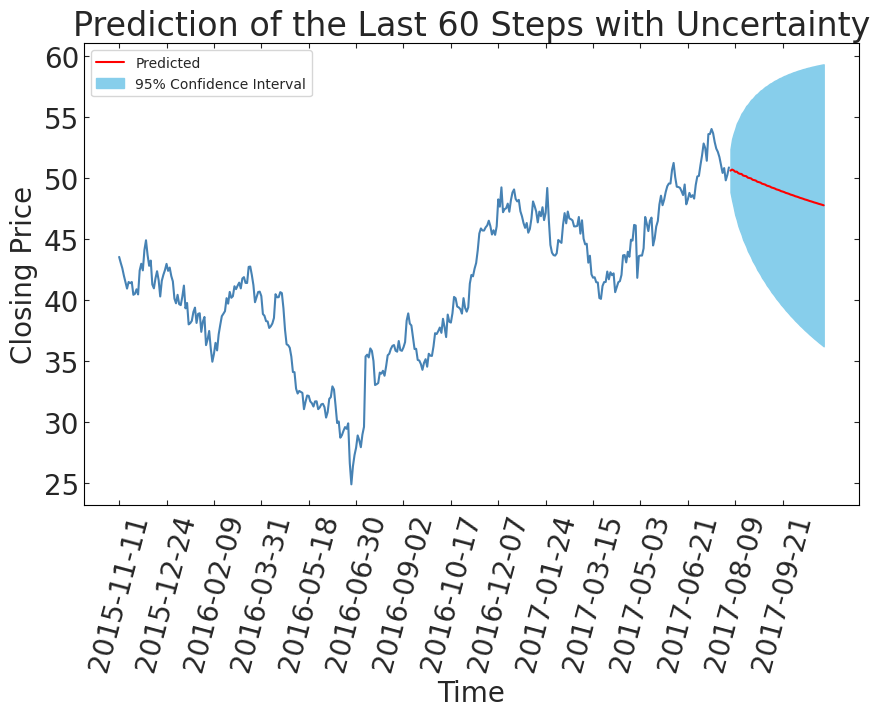

In [110]:
plt.plot(tss.iloc[:-60].index, tss.iloc[:-60][column_name])#, rot=75, lw=2)

forecast = model_fit.get_forecast(60)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)

# Plot the predictions with uncertainty
plt.plot(tss.iloc[-60:].index, yhat, label="Predicted", color="red")
plt.fill_between(tss.iloc[-60:].index,  yhat_conf_int["lower " + column_name],
                 yhat_conf_int["upper " + column_name],
                 color="skyblue",
                 label="95% Confidence Interval")
plt.xticks(tss.index[::30], rotation=75)
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.title("Prediction of the Last 60 Steps with Uncertainty")
plt.legend(fontsize=10)
plt.show()

**Fig. 5:** Time series analysis of AAL.US closing prices. The historical price data (blue line) is compared against ARIMA model forecasts (red line), with the light blue shaded region representing the 95% confidence interval. The forecast exhibits a downward trend with concave curvature, suggesting continued price depreciation. While the confidence interval indicates both upside and downside potential, the widening lower bound in later periods suggests a higher probability of significant price deterioration over time. This asymmetric confidence interval highlights increased downside risk in the longer-term forecast horizon.

In [111]:
column_name = "a.us"
N_test = 60
p = 4
i = 1
q = 3

print("information for a.us")
arma_model = sm.tsa.ARIMA(tss.iloc[:-60][column_name], order=(p, i, q))
model_fit = arma_model.fit()
model_fit.summary()


information for a.us


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   a.us   No. Observations:                  387
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -360.187
Date:                Mon, 17 Mar 2025   AIC                            736.374
Time:                        03:53:29   BIC                            768.021
Sample:                             0   HQIC                           748.924
                                - 387                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8283      0.172      4.805      0.000       0.490       1.166
ar.L2          0.6588      0.252      2.616      0.009       0.165       1.152
ar.L3         -0.5701      0.188     -3.030      0.002      -0.939      -0.201
ar.L4         -0.1556      0.051     -3.078      0.002      -0.255      -0.057
ma.L1         -0.9069      0.173     -5.241      0.000      -1.246      -0.568
ma.L2         -0.6098      0.244     -2.498      0.012      -1.088      -0.131
ma.L3          0.7113      0.175      4.068      0.000       0.369       1.054
sigma2         0.3783      0.020     18.593      0.000       0.338       0.418
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                90.11
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.50
Prob(H) (two-sided):                  0.29   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

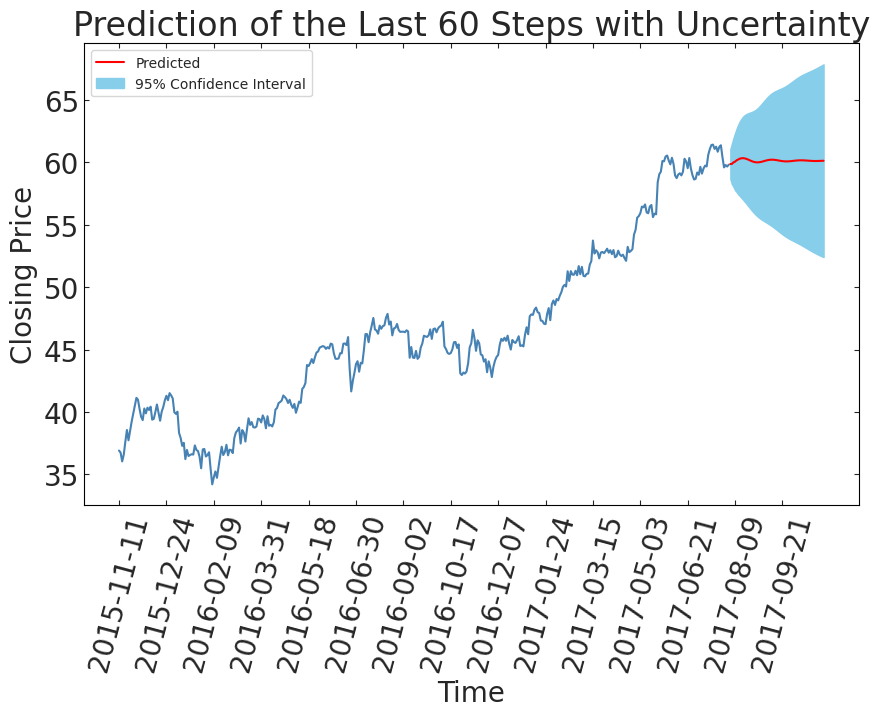

In [112]:
plt.plot(tss.iloc[:-60].index, tss.iloc[:-60][column_name])#, rot=75, lw=2)

forecast = model_fit.get_forecast(60)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)

# Plot the predictions with uncertainty
plt.plot(tss.iloc[-60:].index, yhat, label="Predicted", color="red")
plt.fill_between(tss.iloc[-60:].index,  yhat_conf_int["lower " + column_name],
                 yhat_conf_int["upper " + column_name],
                 color="skyblue",
                 label="95% Confidence Interval")
plt.xticks(tss.index[::30], rotation=75)
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.title("Prediction of the Last 60 Steps with Uncertainty")
plt.legend(fontsize=10)
plt.show()

**Fig. 6**: A.US historical closing prices (blue line) with ARIMA forecast (red line) and 95% confidence interval (blue shading). The forecast shows a flat trajectory with minimal expected price variation. The symmetric confidence bounds suggest balanced upside/downside risk without significant deviations from the trend. This stable pattern indicates A.US likely represents a low-volatility investment with limited growth potential.

In [113]:
column_name = "aa.us"
N_test = 4
p = 7
i = 1
q = 3

print("information for aa.us")
arma_model = sm.tsa.ARIMA(tss.iloc[:-60][column_name], order=(p, i, q))
model_fit = arma_model.fit()
model_fit.summary()


information for aa.us


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  aa.us   No. Observations:                  387
Model:                 ARIMA(7, 1, 3)   Log Likelihood                -437.707
Date:                Mon, 17 Mar 2025   AIC                            897.414
Time:                        03:53:31   BIC                            940.929
Sample:                             0   HQIC                           914.671
                                - 387                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5949      0.074     -8.059      0.000      -0.740      -0.450
ar.L2          0.5518      0.085      6.499      0.000       0.385       0.718
ar.L3          1.0607      0.075     14.155      0.000       0.914       1.208
ar.L4          0.1447      0.064      2.253      0.024       0.019       0.270
ar.L5          0.0022      0.066      0.034      0.973      -0.127       0.131
ar.L6         -0.1413      0.052     -2.735      0.006      -0.243      -0.040
ar.L7         -0.0967      0.054     -1.793      0.073      -0.202       0.009
ma.L1          0.6063      0.057     10.558      0.000       0.494       0.719
ma.L2         -0.5813      0.069     -8.471      0.000      -0.716      -0.447
ma.L3         -0.9697      0.059    -16.562      0.000      -1.084      -0.855
sigma2         0.5630      0.035     16.213      0.000       0.495       0.631
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                80.03
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.72   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

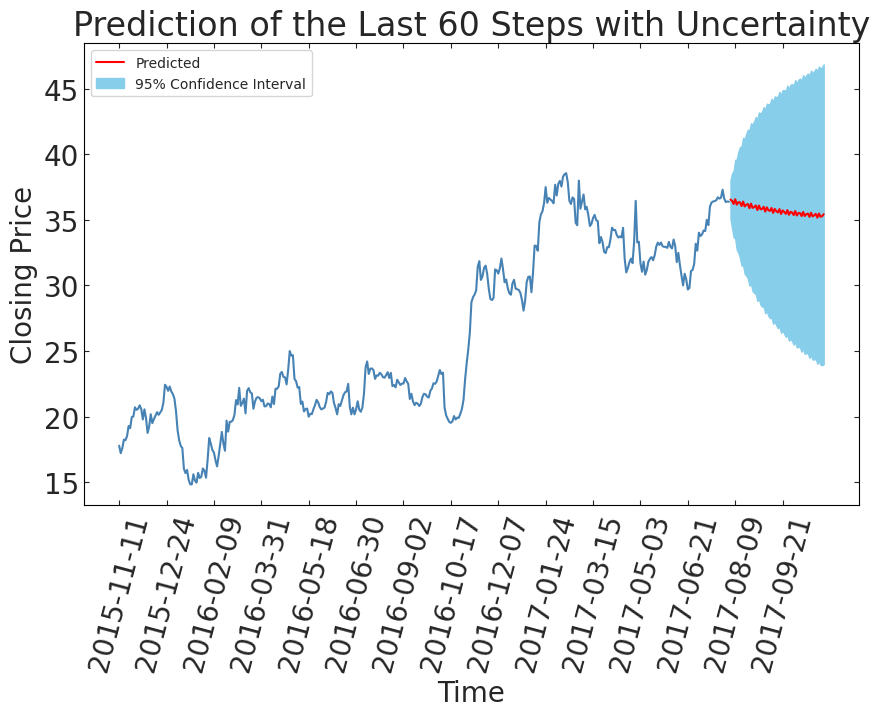

In [114]:
plt.plot(tss.iloc[:-60].index, tss.iloc[:-60][column_name])#, rot=75, lw=2)

forecast = model_fit.get_forecast(60)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)

# Plot the predictions with uncertainty
plt.plot(tss.iloc[-60:].index, yhat, label="Predicted", color="red")
plt.fill_between(tss.iloc[-60:].index,  yhat_conf_int["lower " + column_name],
                 yhat_conf_int["upper " + column_name],
                 color="skyblue",
                 label="95% Confidence Interval")
plt.xticks(tss.index[::30], rotation=75)
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.title("Prediction of the Last 60 Steps with Uncertainty")
plt.legend(fontsize=10)
plt.show()

**Fig. 7**: AA.US historical prices (blue line) with ARIMA forecast (red line) and 95% confidence interval (blue shading). The forecast exhibits slight downward drift while remaining within 2-3 units of starting price. Symmetric confidence bounds indicate balanced risk, with even the upper boundary falling below historical peaks. This pattern suggests limited upside potential, characterizing AA.US as a speculative investment with unfavorable risk-reward profile.

In [115]:
column_name = "aaap.us"
N_test = 60
p = 6
i = 1
q = 3

print("information for aaap.us")
arma_model = sm.tsa.ARIMA(tss.iloc[:-60][column_name], order=(p, i, q))
model_fit = arma_model.fit()
model_fit.summary()


information for aaap.us


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                aaap.us   No. Observations:                  387
Model:                 ARIMA(6, 1, 3)   Log Likelihood                -525.667
Date:                Mon, 17 Mar 2025   AIC                           1071.333
Time:                        03:53:32   BIC                           1110.892
Sample:                             0   HQIC                          1087.021
                                - 387                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5891      0.330     -1.785      0.074      -1.236       0.058
ar.L2          0.6048      0.446      1.357      0.175      -0.269       1.479
ar.L3          0.7435      0.277      2.680      0.007       0.200       1.287
ar.L4          0.0469      0.077      0.608      0.543      -0.104       0.198
ar.L5         -0.0606      0.107     -0.569      0.569      -0.269       0.148
ar.L6          0.0012      0.074      0.016      0.988      -0.144       0.146
ma.L1          0.6048      0.327      1.849      0.064      -0.036       1.246
ma.L2         -0.5721      0.444     -1.290      0.197      -1.441       0.297
ma.L3         -0.6791      0.279     -2.434      0.015      -1.226      -0.132
sigma2         0.8918      0.035     25.381      0.000       0.823       0.961
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               764.14
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

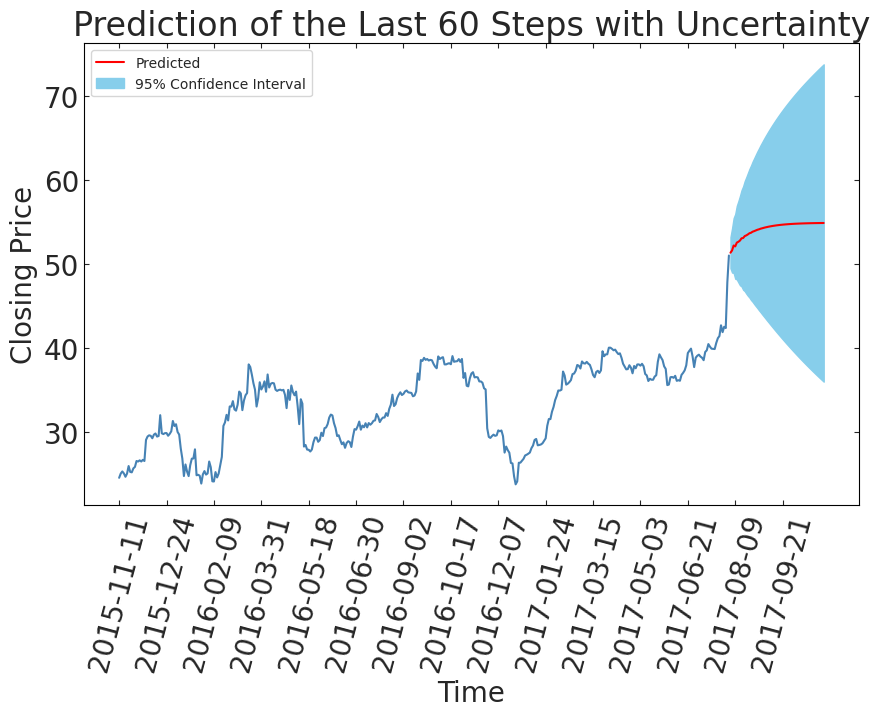

In [116]:
plt.plot(tss.iloc[:-60].index, tss.iloc[:-60][column_name])#, rot=75, lw=2)

forecast = model_fit.get_forecast(60)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)

# Plot the predictions with uncertainty
plt.plot(tss.iloc[-60:].index, yhat, label="Predicted", color="red")
plt.fill_between(tss.iloc[-60:].index,  yhat_conf_int["lower " + column_name],
                 yhat_conf_int["upper " + column_name],
                 color="skyblue",
                 label="95% Confidence Interval")
plt.xticks(tss.index[::30], rotation=75)
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.title("Prediction of the Last 60 Steps with Uncertainty")
plt.legend(fontsize=10)
plt.show()

**Fig. 8**: AAAP.US historical prices (blue line) with ARIMA forecast (red line) and 95% confidence interval (blue shading). The forecast shows logarithmic growth that plateaus over time. The asymmetric confidence interval suggests greater upside potential than downside risk, indicating AAAP.US may represent a favorable investment opportunity with positive risk-reward characteristics.

In [117]:
column_name = "aaba.us"
N_test = 60
p = 6
i = 1
q = 3

print("information for aaba.us")
arma_model = sm.tsa.ARIMA(tss.iloc[:-60][column_name], order=(p, i, q))
model_fit = arma_model.fit()
model_fit.summary()


information for aaba.us


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                aaba.us   No. Observations:                  387
Model:                 ARIMA(6, 1, 3)   Log Likelihood                -396.573
Date:                Mon, 17 Mar 2025   AIC                            813.146
Time:                        03:53:34   BIC                            852.705
Sample:                             0   HQIC                           828.834
                                - 387                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3651      0.138      2.655      0.008       0.096       0.635
ar.L2         -0.5027      0.168     -2.996      0.003      -0.831      -0.174
ar.L3          0.6747      0.128      5.251      0.000       0.423       0.927
ar.L4          0.2338      0.062      3.766      0.000       0.112       0.356
ar.L5         -0.0402      0.060     -0.669      0.504      -0.158       0.078
ar.L6          0.1370      0.067      2.033      0.042       0.005       0.269
ma.L1         -0.5284      0.138     -3.816      0.000      -0.800      -0.257
ma.L2          0.5435      0.162      3.362      0.001       0.227       0.860
ma.L3         -0.8384      0.121     -6.946      0.000      -1.075      -0.602
sigma2         0.4566      0.018     26.087      0.000       0.422       0.491
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1223.01
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.86
Prob(H) (two-sided):                  0.76   Kurtosis:                        11.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

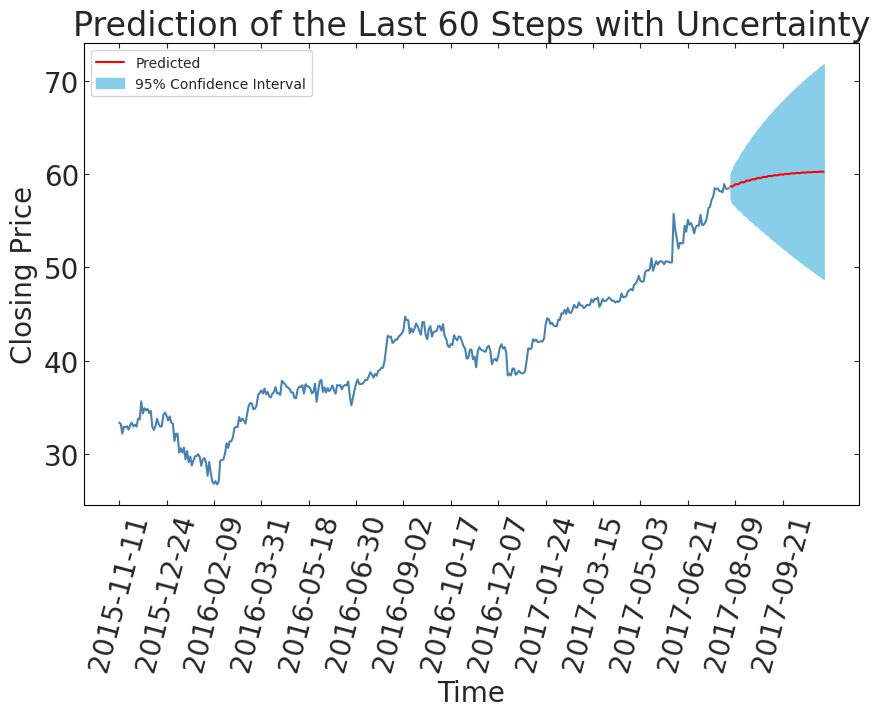

In [118]:
plt.plot(tss.iloc[:-60].index, tss.iloc[:-60][column_name])#, rot=75, lw=2)

forecast = model_fit.get_forecast(60)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)

# Plot the predictions with uncertainty
plt.plot(tss.iloc[-60:].index, yhat, label="Predicted", color="red")
plt.fill_between(tss.iloc[-60:].index,  yhat_conf_int["lower " + column_name],
                 yhat_conf_int["upper " + column_name],
                 color="skyblue",
                 label="95% Confidence Interval")
plt.xticks(tss.index[::30], rotation=75)
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.title("Prediction of the Last 60 Steps with Uncertainty")
plt.legend(fontsize=10)
plt.show()

**Fig. 9**: AABA.US historical prices (blue line) with ARIMA forecast (red line) and 95% confidence interval (blue shading). The forecast shows modest upward movement of approximately 2-3 units over the prediction period. The symmetric confidence interval indicates balanced upside and downside risk. This pattern suggests AABA.US represents a moderate investment opportunity with reasonable but unexceptional growth potential.

In [119]:
column_name = "aac.us"
N_test = 60
p = 7
i = 1
q = 3

print("information for aac.us")
arma_model = sm.tsa.ARIMA(tss.iloc[:-60][column_name], order=(p, i, q))
model_fit = arma_model.fit()
model_fit.summary()


information for aac.us


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 aac.us   No. Observations:                  387
Model:                 ARIMA(7, 1, 3)   Log Likelihood                -400.623
Date:                Mon, 17 Mar 2025   AIC                            823.245
Time:                        03:53:37   BIC                            866.759
Sample:                             0   HQIC                           840.501
                                - 387                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2437     28.838      0.008      0.993     -56.279      56.766
ar.L2          0.6647      4.631      0.144      0.886      -8.412       9.742
ar.L3         -0.2697     17.875     -0.015      0.988     -35.304      34.764
ar.L4          0.0299      0.688      0.043      0.965      -1.318       1.378
ar.L5         -0.0980      0.590     -0.166      0.868      -1.254       1.058
ar.L6         -0.0391      2.623     -0.015      0.988      -5.181       5.103
ar.L7          0.0265      2.215      0.012      0.990      -4.316       4.369
ma.L1         -0.2118     28.842     -0.007      0.994     -56.742      56.318
ma.L2         -0.6523      5.551     -0.117      0.906     -11.533      10.228
ma.L3          0.2366     17.143      0.014      0.989     -33.364      33.837
sigma2         0.4665      0.013     35.866      0.000       0.441       0.492
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             53150.55
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -4.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        59.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

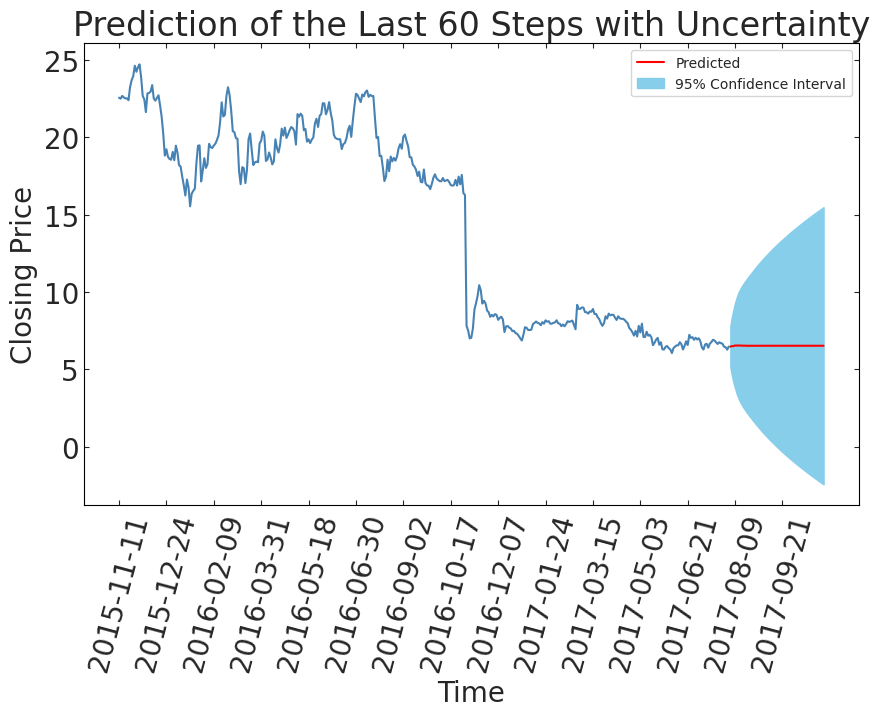

In [120]:
plt.plot(tss.iloc[:-60].index, tss.iloc[:-60][column_name])#, rot=75, lw=2)

forecast = model_fit.get_forecast(60)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)

# Plot the predictions with uncertainty
plt.plot(tss.iloc[-60:].index, yhat, label="Predicted", color="red")
plt.fill_between(tss.iloc[-60:].index,  yhat_conf_int["lower " + column_name],
                 yhat_conf_int["upper " + column_name],
                 color="skyblue",
                 label="95% Confidence Interval")
plt.xticks(tss.index[::30], rotation=75)
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.title("Prediction of the Last 60 Steps with Uncertainty")
plt.legend(fontsize=10)
plt.show()

**Fig. 10**: AAC.US historical prices (blue line) with ARIMA forecast (red line) and 95% confidence interval (blue shading). The forecast shows a flat trajectory that fails to recover toward previous historical peaks. Symmetric confidence bounds indicate balanced risk, with even the upper boundary remaining well below earlier highs. This pattern suggests AAC.US offers limited upside potential, representing a high-risk, low-reward investment proposition.

In [121]:
column_name = "aamc.us"
N_test = 60
p = 4
i = 1
q = 3

print("information for aamc.us")
arma_model = sm.tsa.ARIMA(tss.iloc[:-60][column_name], order=(p, i, q))
model_fit = arma_model.fit()
model_fit.summary()


information for aamc.us


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                aamc.us   No. Observations:                  387
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -900.778
Date:                Mon, 17 Mar 2025   AIC                           1817.556
Time:                        03:53:39   BIC                           1849.202
Sample:                             0   HQIC                          1830.106
                                - 387                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7405      2.263     -0.327      0.743      -5.175       3.694
ar.L2          0.8275      3.887      0.213      0.831      -6.792       8.447
ar.L3          0.8134      1.908      0.426      0.670      -2.926       4.552
ar.L4         -0.0034      0.047     -0.073      0.942      -0.096       0.089
ma.L1          0.8159      2.264      0.360      0.719      -3.621       5.253
ma.L2         -0.8153      4.048     -0.201      0.840      -8.750       7.119
ma.L3         -0.8937      2.082     -0.429      0.668      -4.974       3.186
sigma2         6.2255      0.218     28.597      0.000       5.799       6.652
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1321.76
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               5.77   Skew:                             1.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

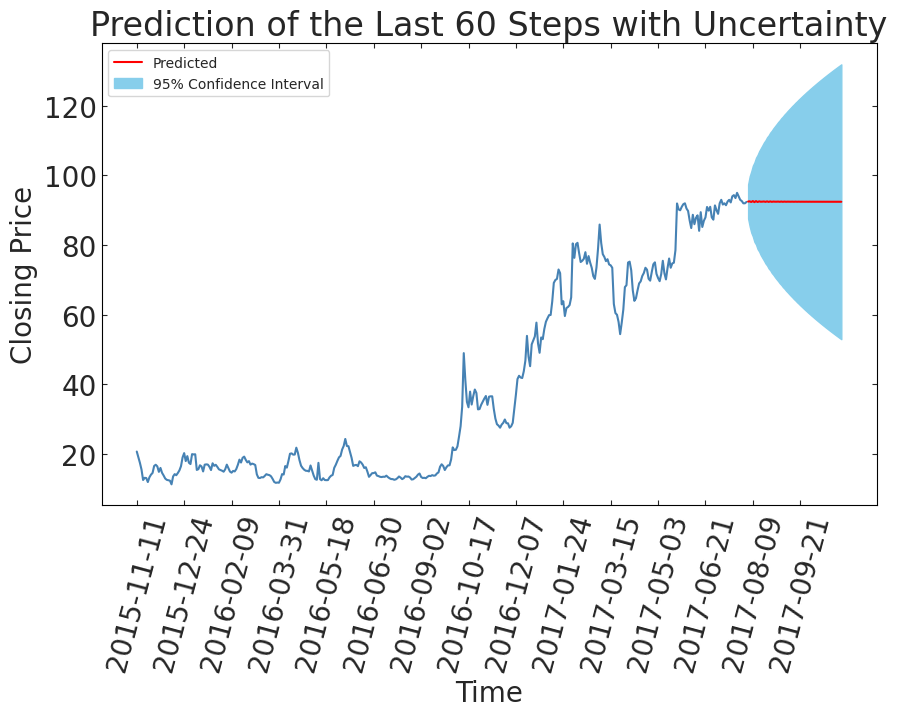

In [122]:
plt.plot(tss.iloc[:-60].index, tss.iloc[:-60][column_name])#, rot=75, lw=2)

forecast = model_fit.get_forecast(60)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)

# Plot the predictions with uncertainty
plt.plot(tss.iloc[-60:].index, yhat, label="Predicted", color="red")
plt.fill_between(tss.iloc[-60:].index,  yhat_conf_int["lower " + column_name],
                 yhat_conf_int["upper " + column_name],
                 color="skyblue",
                 label="95% Confidence Interval")
plt.xticks(tss.index[::30], rotation=75)
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.title("Prediction of the Last 60 Steps with Uncertainty")
plt.legend(fontsize=10)
plt.show()

**Fig. 11**: AAMC.US historical prices (blue line) with ARIMA forecast (red line) and 95% confidence interval (blue shading). The forecast projects a flat trajectory that diverges from the recent upward momentum observed in historical data. Symmetric confidence bounds indicate balanced risk without directional bias. This disconnect between recent bullish performance and neutral forecast suggests AAMC.US presents a cautious investment opportunity with uncertain return potential.

In [123]:
column_name = "aame.us"
N_test = 60
p = 2
i = 0
q = 3

# print("information for aame.us")
arma_model = sm.tsa.ARIMA(tss.iloc[:-60][column_name], order=(p, i, q))
model_fit = arma_model.fit()
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                aame.us   No. Observations:                  387
Model:                 ARIMA(2, 0, 3)   Log Likelihood                 249.324
Date:                Mon, 17 Mar 2025   AIC                           -484.647
Time:                        03:53:41   BIC                           -456.938
Sample:                             0   HQIC                          -473.660
                                - 387                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9933      0.176     22.628      0.000       3.647       4.339
ar.L1          0.1910      1.788      0.107      0.915      -3.314       3.696
ar.L2          0.7670      1.748      0.439      0.661      -2.659       4.193
ma.L1          0.5235      1.789      0.293      0.770      -2.983       4.030
ma.L2         -0.2082      0.469     -0.444      0.657      -1.128       0.712
ma.L3          0.0059      0.057      0.104      0.917      -0.106       0.118
sigma2         0.0160      0.001     18.980      0.000       0.014       0.018
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                72.88
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

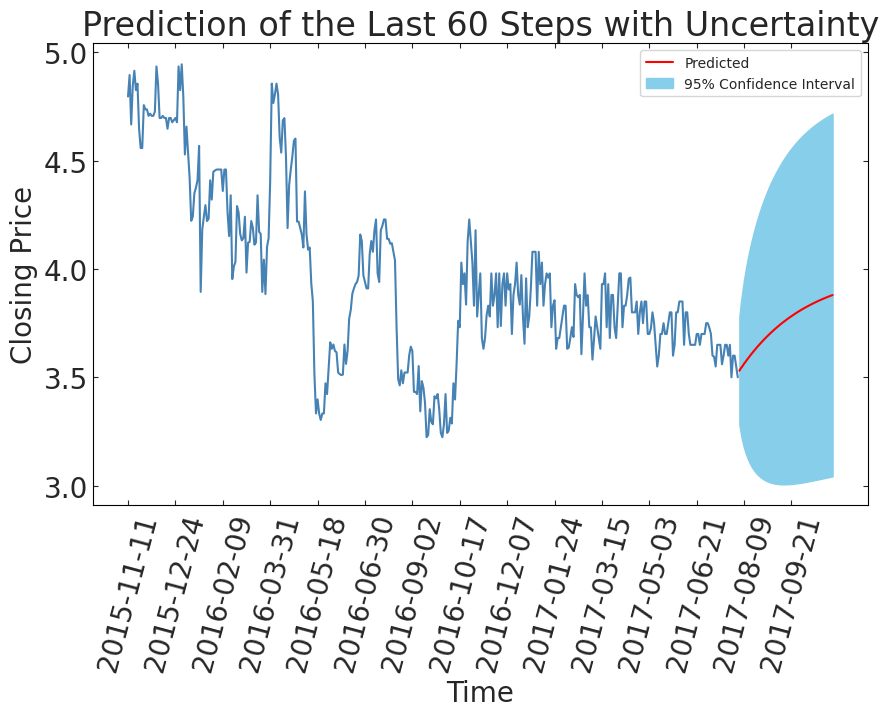

In [124]:
plt.plot(tss.iloc[:-60].index, tss.iloc[:-60][column_name])#, rot=75, lw=2)

forecast = model_fit.get_forecast(60)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)

# Plot the predictions with uncertainty
plt.plot(tss.iloc[-60:].index, yhat, label="Predicted", color="red")
plt.fill_between(tss.iloc[-60:].index,  yhat_conf_int["lower " + column_name],
                 yhat_conf_int["upper " + column_name],
                 color="skyblue",
                 label="95% Confidence Interval")
plt.xticks(tss.index[::30], rotation=75)
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.title("Prediction of the Last 60 Steps with Uncertainty")
plt.legend(fontsize=10)
plt.show()

Fig. 12: Historical closing prices (blue) and ARIMA forecasts (red) for AAME.US, with a 95% confidence interval (shaded blue). The model predicts gradual growth but highlights early downside risk and volatility. While an upward trend is expected, cautious optimism is advised due to near-term fluctuations.

In [125]:
column_name = "aan.us"
N_test = 60
p = 6
i = 1
q = 3

print("information for aan.us")
arma_model = sm.tsa.ARIMA(tss.iloc[:-60][column_name], order=(p, i, q))
model_fit = arma_model.fit()
model_fit.summary()


information for aan.us


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 aan.us   No. Observations:                  387
Model:                 ARIMA(6, 1, 3)   Log Likelihood                -407.077
Date:                Mon, 17 Mar 2025   AIC                            834.153
Time:                        03:53:42   BIC                            873.712
Sample:                             0   HQIC                           849.841
                                - 387                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3445      0.973     -0.354      0.723      -2.251       1.562
ar.L2         -0.5755      0.469     -1.227      0.220      -1.495       0.344
ar.L3         -0.6455      0.802     -0.805      0.421      -2.217       0.926
ar.L4          0.0369      0.080      0.459      0.646      -0.121       0.195
ar.L5         -0.0141      0.085     -0.166      0.868      -0.181       0.153
ar.L6          0.0226      0.079      0.285      0.775      -0.132       0.178
ma.L1          0.3155      0.983      0.321      0.748      -1.610       2.241
ma.L2          0.5393      0.474      1.139      0.255      -0.389       1.468
ma.L3          0.6744      0.799      0.844      0.399      -0.892       2.241
sigma2         0.4815      0.015     31.969      0.000       0.452       0.511
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              4742.68
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               2.35   Skew:                             1.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

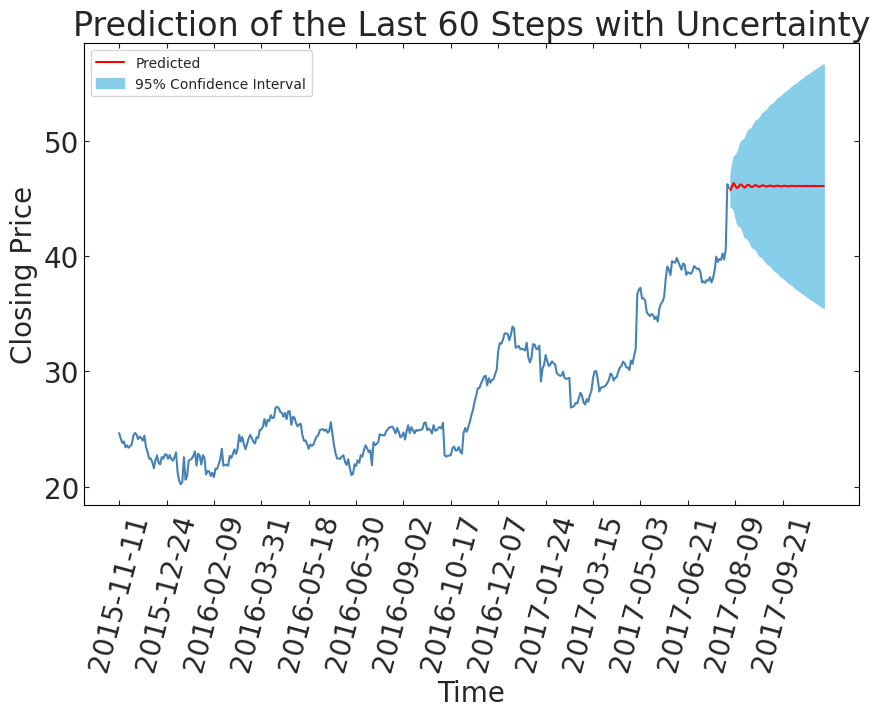

In [126]:
plt.plot(tss.iloc[:-60].index, tss.iloc[:-60][column_name])#, rot=75, lw=2)

forecast = model_fit.get_forecast(60)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)

# Plot the predictions with uncertainty
plt.plot(tss.iloc[-60:].index, yhat, label="Predicted", color="red")
plt.fill_between(tss.iloc[-60:].index,  yhat_conf_int["lower " + column_name],
                 yhat_conf_int["upper " + column_name],
                 color="skyblue",
                 label="95% Confidence Interval")
plt.xticks(tss.index[::30], rotation=75)
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.title("Prediction of the Last 60 Steps with Uncertainty")
plt.legend(fontsize=10)
plt.show()

Fig. 13: Historical prices (blue) and ARIMA forecasts (red) for AAN.US, with a 95% confidence interval (shaded blue). The model predicts stability with no clear trend, suggesting limited profit potential amid persistent uncertainty.

In [127]:
column_name = "aaoi.us"
N_test = 60
p = 18
i = 1
q = 3

print("information for aaoi.us")
arma_model = sm.tsa.ARIMA(tss.iloc[:-60][column_name], order=(p, i, q))
model_fit = arma_model.fit()
model_fit.summary()


information for aaoi.us


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                aaoi.us   No. Observations:                  387
Model:                ARIMA(18, 1, 3)   Log Likelihood                -731.687
Date:                Mon, 17 Mar 2025   AIC                           1507.374
Time:                        03:53:46   BIC                           1594.403
Sample:                             0   HQIC                          1541.887
                                - 387                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4737      0.142     -3.330      0.001      -0.752      -0.195
ar.L2          0.5296      0.124      4.266      0.000       0.286       0.773
ar.L3          0.5111      0.123      4.157      0.000       0.270       0.752
ar.L4          0.1338      0.056      2.394      0.017       0.024       0.243
ar.L5         -0.0275      0.069     -0.399      0.690      -0.162       0.107
ar.L6         -0.0474      0.068     -0.702      0.483      -0.180       0.085
ar.L7          0.0424      0.043      0.987      0.324      -0.042       0.127
ar.L8          0.0093      0.060      0.155      0.876      -0.108       0.127
ar.L9         -0.0913      0.074     -1.239      0.215      -0.236       0.053
ar.L10        -0.1203      0.058     -2.083      0.037      -0.233      -0.007
ar.L11         0.0051      0.056      0.092      0.927      -0.105       0.115
ar.L12         0.0402      0.061      0.664      0.507      -0.078       0.159
ar.L13         0.0350      0.058      0.604      0.546      -0.079       0.149
ar.L14         0.0679      0.052      1.297      0.194      -0.035       0.170
ar.L15         0.0551      0.064      0.860      0.390      -0.071       0.181
ar.L16         0.0969      0.058      1.668      0.095      -0.017       0.211
ar.L17        -0.1089      0.058     -1.891      0.059      -0.222       0.004
ar.L18        -0.2757      0.040     -6.824      0.000      -0.355      -0.197
ma.L1          0.4869      0.150      3.249      0.001       0.193       0.781
ma.L2         -0.4444      0.134     -3.315      0.001      -0.707      -0.182
ma.L3         -0.3913      0.128     -3.056      0.002      -0.642      -0.140
sigma2         2.5812      0.102     25.424      0.000       2.382       2.780
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):              1054.93
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):              14.37   Skew:                             1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

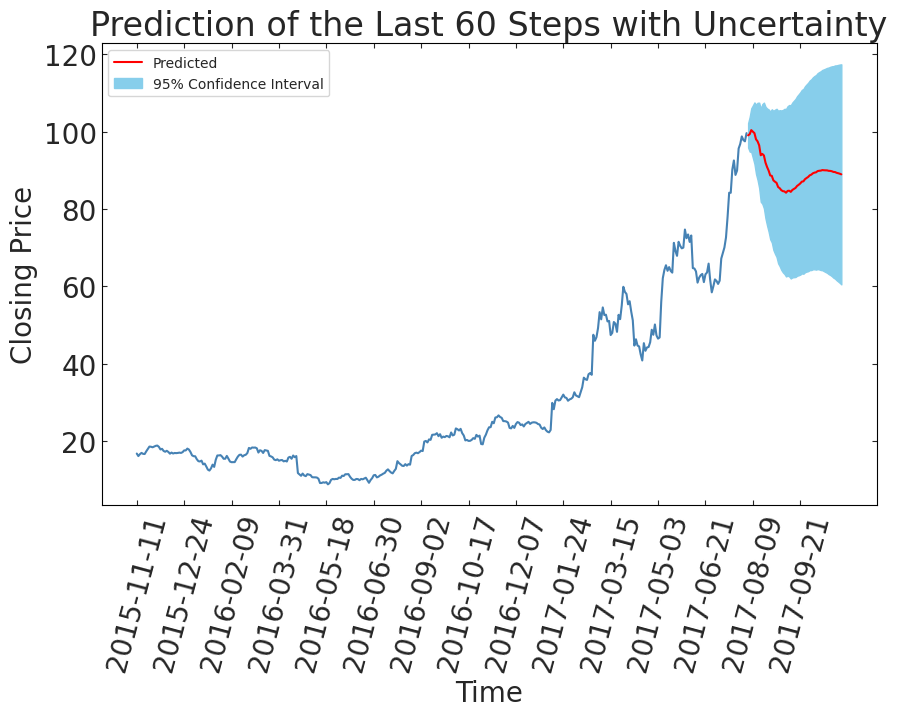

In [128]:
plt.plot(tss.iloc[:-60].index, tss.iloc[:-60][column_name])#, rot=75, lw=2)

forecast = model_fit.get_forecast(60)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)

# Plot the predictions with uncertainty
plt.plot(tss.iloc[-60:].index, yhat, label="Predicted", color="red")
plt.fill_between(tss.iloc[-60:].index,  yhat_conf_int["lower " + column_name],
                 yhat_conf_int["upper " + column_name],
                 color="skyblue",
                 label="95% Confidence Interval")
plt.xticks(tss.index[::30], rotation=75)
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.title("Prediction of the Last 60 Steps with Uncertainty")
plt.legend(fontsize=10)
plt.show()

Fig. 14: Closing prices (blue) and ARIMA forecast (red) for AAOI.US, with a 95% confidence interval (shaded blue). The model predicts an overall decline with brief recovery, heightened downside risk, and limited profit potential.

In [129]:
column_name = "aaon.us"
N_test = 60
p = 17
i = 1
q = 3

print("information for aaon.us")
arma_model = sm.tsa.ARIMA(tss.iloc[:-60][column_name], order=(p, i, q))
model_fit = arma_model.fit()
model_fit.summary()


information for aaon.us


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                aaon.us   No. Observations:                  387
Model:                ARIMA(17, 1, 3)   Log Likelihood                -294.963
Date:                Mon, 17 Mar 2025   AIC                            631.926
Time:                        03:53:54   BIC                            714.999
Sample:                             0   HQIC                           664.870
                                - 387                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0864      0.394      0.219      0.826      -0.685       0.858
ar.L2         -0.2539      0.321     -0.790      0.429      -0.883       0.376
ar.L3          0.8621      0.397      2.170      0.030       0.084       1.641
ar.L4         -0.0389      0.081     -0.480      0.631      -0.198       0.120
ar.L5         -0.0345      0.081     -0.428      0.669      -0.192       0.123
ar.L6         -0.0458      0.076     -0.601      0.548      -0.195       0.103
ar.L7         -0.0070      0.094     -0.075      0.940      -0.191       0.177
ar.L8          0.0023      0.089      0.026      0.980      -0.173       0.177
ar.L9          0.0254      0.091      0.280      0.780      -0.152       0.203
ar.L10         0.0221      0.081      0.274      0.784      -0.136       0.180
ar.L11         0.0519      0.081      0.640      0.522      -0.107       0.211
ar.L12        -0.0290      0.080     -0.361      0.718      -0.186       0.128
ar.L13        -0.0435      0.087     -0.501      0.616      -0.213       0.127
ar.L14        -0.0360      0.075     -0.477      0.633      -0.184       0.112
ar.L15        -0.0041      0.066     -0.062      0.951      -0.133       0.125
ar.L16         0.0219      0.066      0.333      0.739      -0.107       0.151
ar.L17         0.0737      0.061      1.209      0.227      -0.046       0.193
ma.L1         -0.1007      0.397     -0.254      0.800      -0.878       0.677
ma.L2          0.2710      0.320      0.848      0.396      -0.355       0.897
ma.L3         -0.8671      0.392     -2.213      0.027      -1.635      -0.099
sigma2         0.2684      0.013     20.819      0.000       0.243       0.294
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               236.41
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.52
Prob(H) (two-sided):                  0.65   Kurtosis:                         6.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

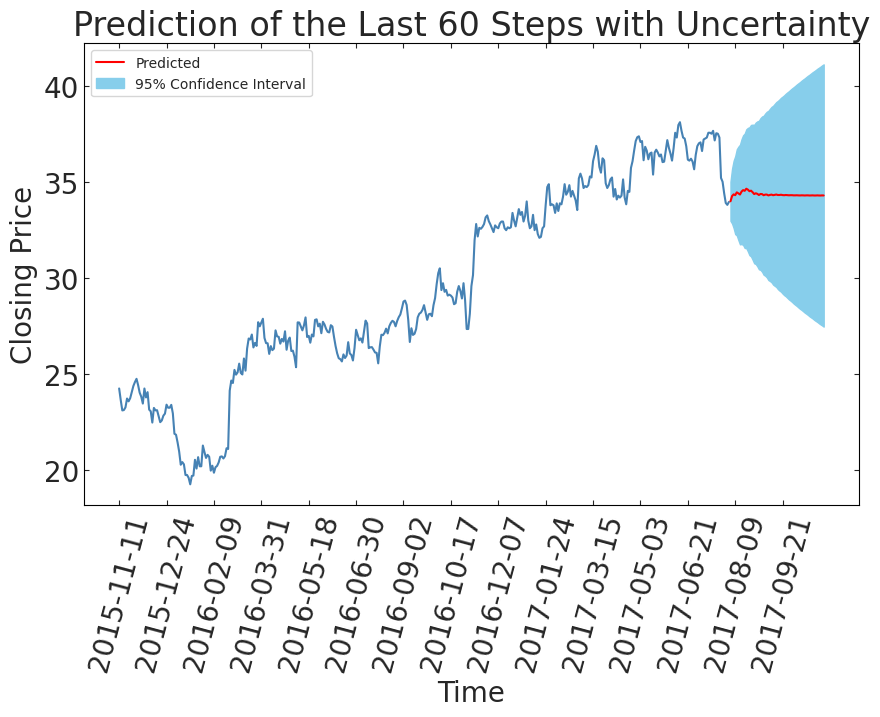

In [130]:
plt.plot(tss.iloc[:-60].index, tss.iloc[:-60][column_name])#, rot=75, lw=2)

forecast = model_fit.get_forecast(60)
yhat = forecast.predicted_mean
yhat_conf_int = forecast.conf_int(alpha=0.05)

# Plot the predictions with uncertainty
plt.plot(tss.iloc[-60:].index, yhat, label="Predicted", color="red")
plt.fill_between(tss.iloc[-60:].index,  yhat_conf_int["lower " + column_name],
                 yhat_conf_int["upper " + column_name],
                 color="skyblue",
                 label="95% Confidence Interval")
plt.xticks(tss.index[::30], rotation=75)
plt.xlabel("Time")
plt.ylabel("Closing Price")
plt.title("Prediction of the Last 60 Steps with Uncertainty")
plt.legend(fontsize=10)
plt.show()

Fig. 15: Closing prices (blue) and ARIMA forecast (red) for AAON, with a 95% confidence interval (shaded blue). The forecast shows initial growth, followed by decline and stabilization. Symmetrical uncertainty and limited upside suggest a cautious investment outlook.